In [1]:
import validation

In [2]:
# Fill in your names using the format below

your_name = "Rangaraj, Pavan Aakash"

In [3]:
# For use in colab
if 'google.colab' in str(get_ipython()):
  !python -m pip install geopandas contextily openml dirty_cat category_encoders gensim==3.8.3 --quiet

# Machine Learning Engineering - Assignment 2

This assignment will be all about building machine learning models on real-world data. We'll be looking at a challenging dataset containing more than 200,000 Airbnb listings in the United States. It is a good example of a real-world dataset combining multiple types of data (numeric, categorical, text, latitudes/longitudes, dates,...) and various real-world issues such as missing data and high-cardinality categorical features. You will need to do a lot of smart preprocessing and good model selection in order to build an well-working model. The main challenge will be to predict the price of Airbnb rentals based all the available data. Feel free to learn more about the dataset [here](https://www.openml.org/d/43369), and more about the meaning of the features [here](https://github.com/UBC-MDS/522_Airbnb_Listings_Amsterdam/blob/master/doc/main_report.md).

In [4]:
# imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml

### Additional packages:
* Geopandas and contextily (plot maps)
    - Run `pip install geopandas contextily shapely`
* dirty_cat (GAP feature encoding)
    - Run `pip install dirty_cat`
* category encoders (for target encoding)
    - Run `pip install category_encoders`
* gensim (for NLP)
    - Run `pip install "gensim==3.8.3"`

In [5]:
# Pre-flight checklist. Do not change this code.
# Make sure that you have installed recent versions of key packages.
# You could lose points if these checks do not pass.
from packaging import version
import sklearn
import seaborn as sns
from tqdm.notebook import tqdm
sklearn_version = sklearn.__version__
if version.parse(sklearn_version) < version.parse("1.2.0"):
    print("scikit-learn is outdated: {}. Please update now! pip install -U scikit-learn".format(sklearn_version))
else:
    print("OK. You may continue :)")

OK. You may continue :)


## Data loading and cleaning
We'll first load the data and select the aspects that are useful for our problem.

In [6]:
# Download AirBnb data. Do not change this code and don't overwrite X or y.
# Note that X is a pandas dataframe 
airbnb = openml.datasets.get_dataset(43369)
X, y, _, feat_names = airbnb.get_data(target=airbnb.default_target_attribute)
print("The original data has {} rows and {} features".format(*X.shape))

The original data has 226030 rows and 17 features


In [7]:
from sklearn.model_selection import train_test_split

# Remove columns that are clearly not relevant to predict pricing
# The list ID is unique so it must be removed
# The host ID and host name are almost unique and not very useful either
# Last review is a date, which requires special handling, plus it is likely not very useful
X.drop(['id', 'host_id', 'host_name', 'last_review'], axis = 1, inplace = True)

# 'neighbourhood_group' is often missing but the dataset is very large.
# We'll drop the rows where this feature is missing so that we can also train models faster in this assignment.
X.dropna(subset=['neighbourhood_group'], inplace = True)
X.reset_index()

# Convert object columns to categorical columns
X.loc[:, X.dtypes == 'object'] = X.select_dtypes(['object']).apply(lambda x: x.astype('category'))


# 'name' is a short textual description, requiring NLP. We'll remove it for now and incorporate it later.
airbnb_names = X['name'].fillna(" ")
X.drop(['name'], axis = 1, inplace = True)

# We'll focus mainly on predicting the price of an airbnb given all information
# Setting the target (y) to be the price since this wasn't specified with the dataset
y = X['price']
X.drop('price', axis = 1, inplace = True)

print("The cleaned data has {} rows and {} features".format(*X.shape))

The cleaned data has 110185 rows and 11 features


C:\Users\pavan\AppData\Local\Temp\ipykernel_3124\175127488.py:15: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, X.dtypes == 'object'] = X.select_dtypes(['object']).apply(lambda x: x.astype('category'))


### Data splits
We're making a few train-test splits to evaluate our models. Don't change or overwrite these!


In [8]:
# Taking a 50-50 train/test split. The dataset is quite large and this will speed up the training further
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

## Quick analysis
Let's peak at the data and how it's distributed.

In [412]:
X

neighbourhood_group        neighbourhood   latitude   longitude  \
48150                Hawaii              Hamakua  20.040950 -155.432510   
48151                Hawaii         South Kohala  20.027400 -155.702000   
48152                Hawaii           South Kona  19.431190 -155.880790   
48153                Hawaii           North Kona  19.564130 -155.963470   
48154                 Kauai          Koloa-Poipu  21.883050 -159.473720   
...                     ...                  ...        ...         ...   
212205              Cascade     South Lake Union  47.624490 -122.335400   
212206             Downtown             Belltown  47.615020 -122.342490   
212207           Queen Anne      West Queen Anne  47.639570 -122.360840   
212208             Downtown             Belltown  47.615070 -122.340490   
212209  University District  University District  47.660222 -122.316817   

              room_type  minimum_nights  number_of_reviews  reviews_per_month  \
48150   Entire home/apt               2                 42               0.45   
48151   Entire home/apt              30                 10               0.09   
48152   Entire home/apt               5                168               1.30   
48153   Entire home/apt               6                 20               0.24   
48154   Entire home/apt               3                143               1.03   
...                 ...             ...                ...                ...   
212205  Entire home/apt              30                  0                NaN   
212206  Entire home/apt               1                  0                NaN   
212207  Entire home/apt               1                  0                NaN   
212208  Entire home/apt               1                  0                NaN   
212209  Entire home/apt              30                  0                NaN   

        calculated_host_listings_count  availability_365     city  
48150                                2               365   Hawaii  
48151                                5               261   Hawaii  
48152                                3               242   Hawaii  
48153                                3               287   Hawaii  
48154                                1               116   Hawaii  
...                                ...               ...      ...  
212205                              29                90  Seattle  
212206                               9                82  Seattle  
212207                              12               328  Seattle  
212208                               9                74  Seattle  
212209                               1                74  Seattle  

[110185 rows x 11 columns]

### Geographical analysis

We can use the latitudes and longitudes for map their geographical distribution. The data is apparently only from NY, Washington, LA, Rhode Island, Seattle, and Hawaii, so we'll zoom in on these individually. We color-code the places by their price, from blue (cheap) to red (expensive), to check whether location tells us much about price. In New York, the effect of location is very mixed. For Hawai there seem to be some relationships. In any case, models should be able to handle complex local patterns to benefit from this.

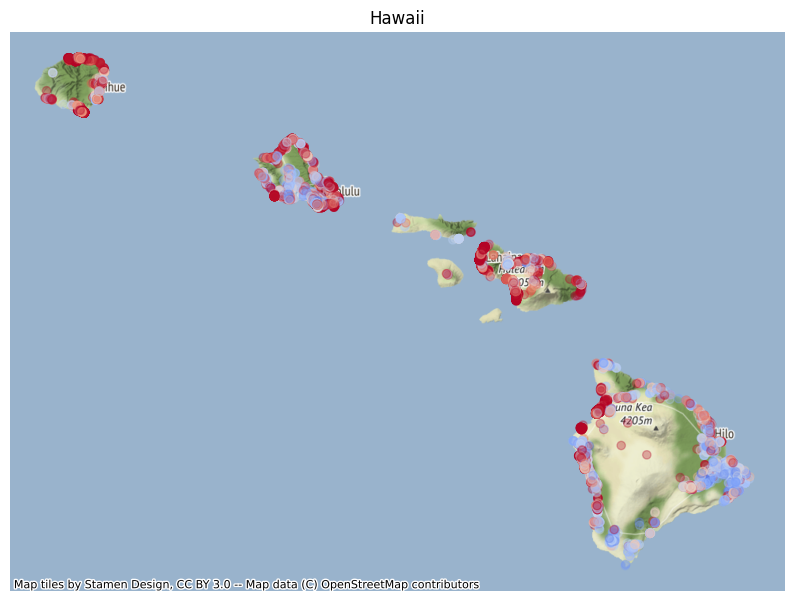

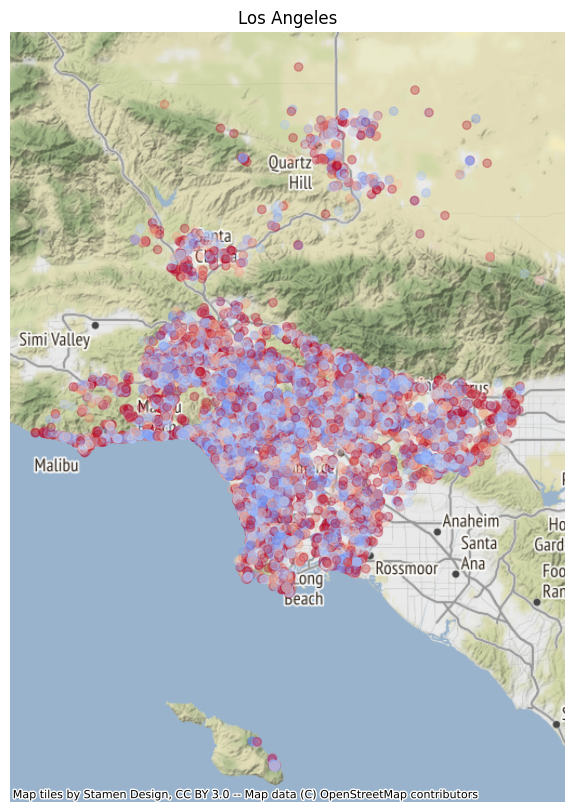

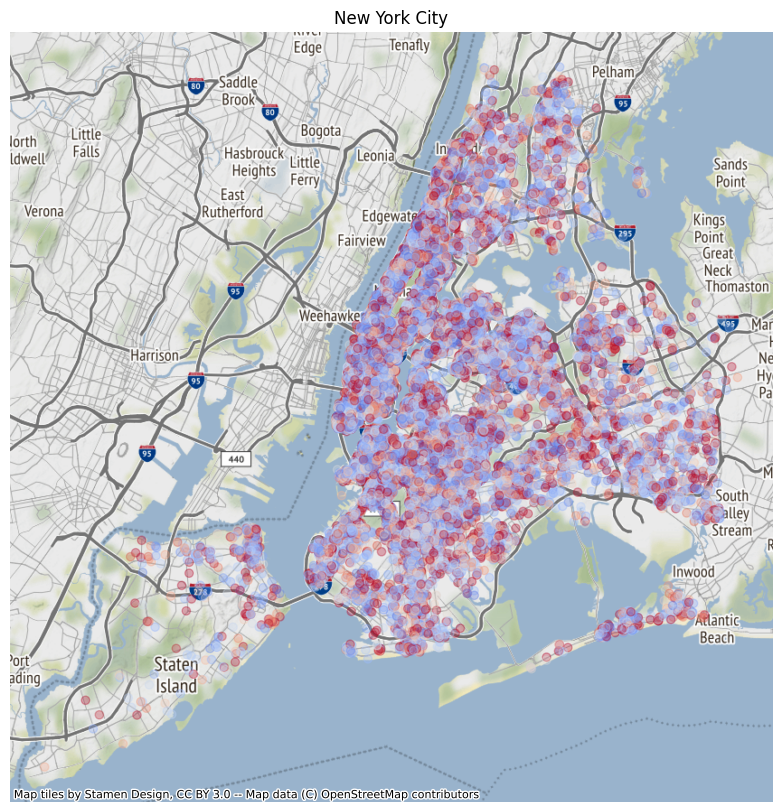

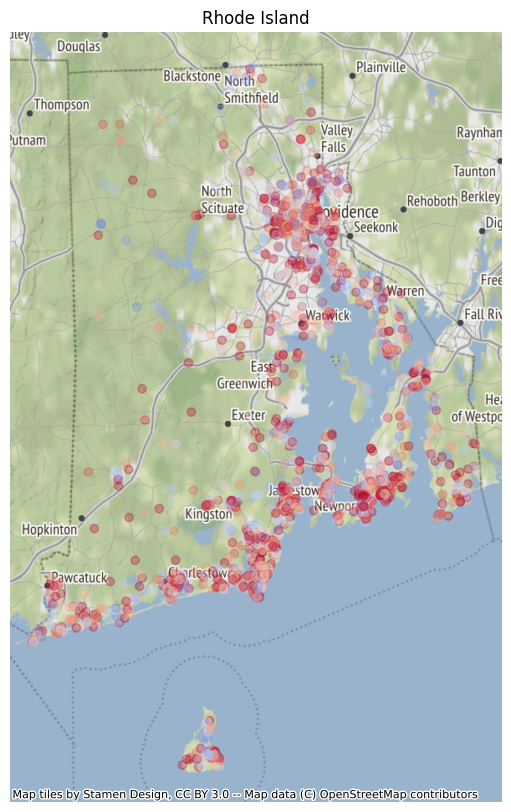

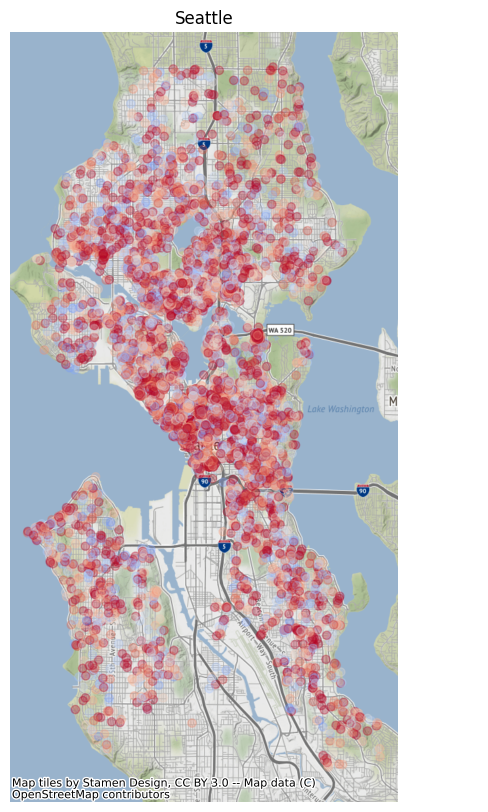

In [413]:
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
import matplotlib.cm as cm

def plot_geo(X, color):
  """
  Plots the data points of X on a map, color-coded by the `color` value
  """
  gdf = gpd.GeoDataFrame(X, geometry=gpd.points_from_xy(X.longitude, X.latitude), crs="EPSG:4326")
  df_wm = gdf.to_crs(epsg=3857)
  ax = df_wm.plot(figsize=(10, 10), alpha=0.3, c=cm.coolwarm(color))
  cx.add_basemap(ax)
  plt.axis('off')

for city in X.city.unique():
  X_city = X[X.city==city]
  plot_geo(X_city,y)
  plt.title(city)

### Categorical features
There is an interesting mix of categorical and numeric features that will require more complex pipelines.

In [414]:
X.dtypes

neighbourhood_group               category
neighbourhood                     category
latitude                           float64
longitude                          float64
room_type                         category
minimum_nights                       int64
number_of_reviews                    int64
reviews_per_month                  float64
calculated_host_listings_count       int64
availability_365                     int64
city                              category
dtype: object

Neighborhood is a categorical feature with a *lot* of possible categories (635) and a long tail distribution. Here are the largest 100 categories:

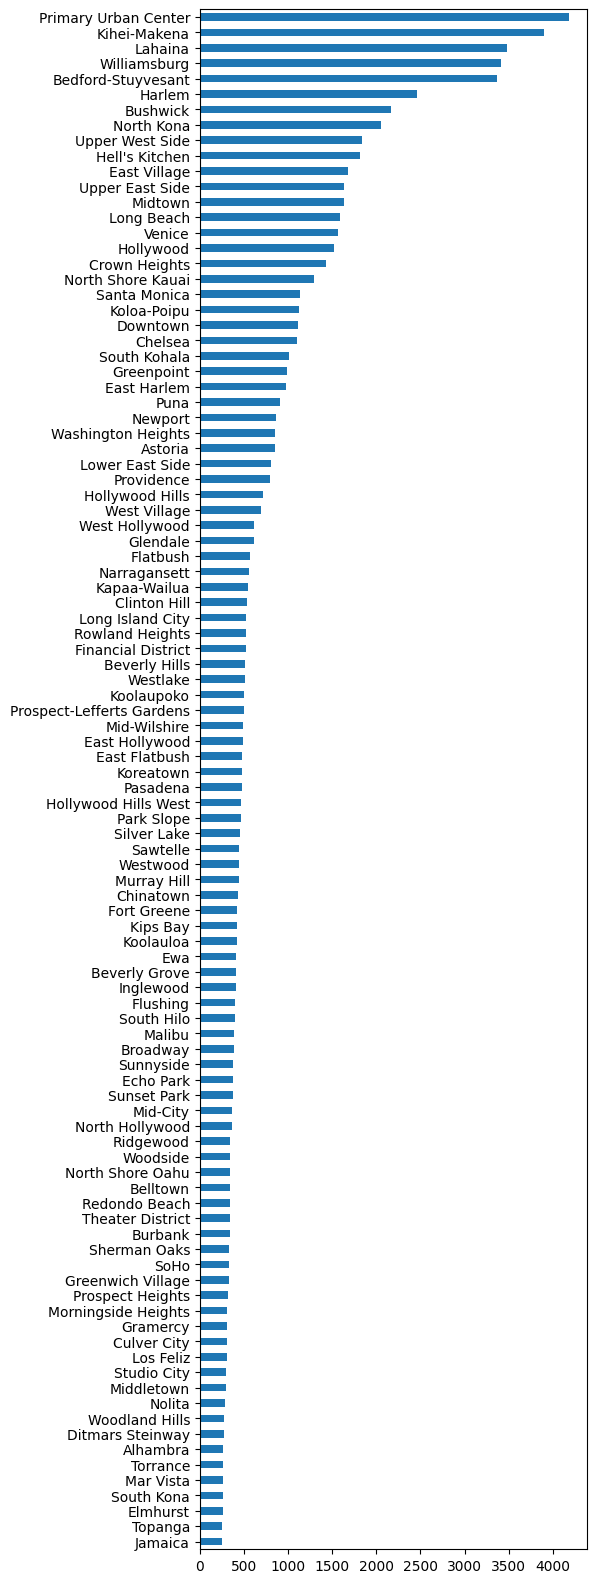

In [415]:
X.neighbourhood.value_counts().head(100)[::-1].plot(kind='barh', figsize=(5,20));

`Neighborhood_group` groups all neighborhoods in 34 categories.

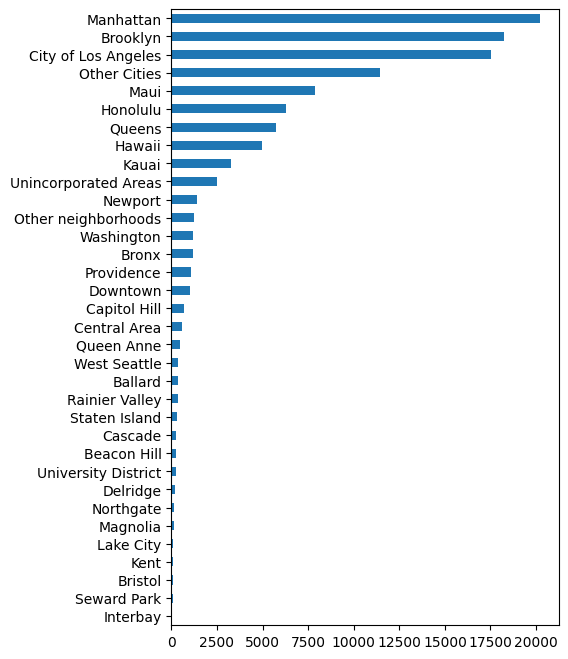

In [416]:
X.neighbourhood_group.value_counts()[::-1].plot(kind='barh', figsize=(5,8));

Most rooms are entire homes/appartments or private rooms.

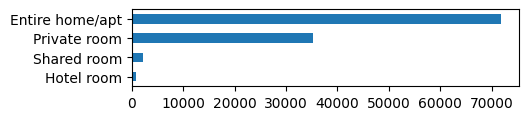

In [417]:
X.room_type.value_counts()[::-1].plot(kind='barh', figsize=(5,1));

### Numeric features
Distributions of all numeric features. In the second plot, we can see that expensive places usually have few reviews and can be rented any time of the year.

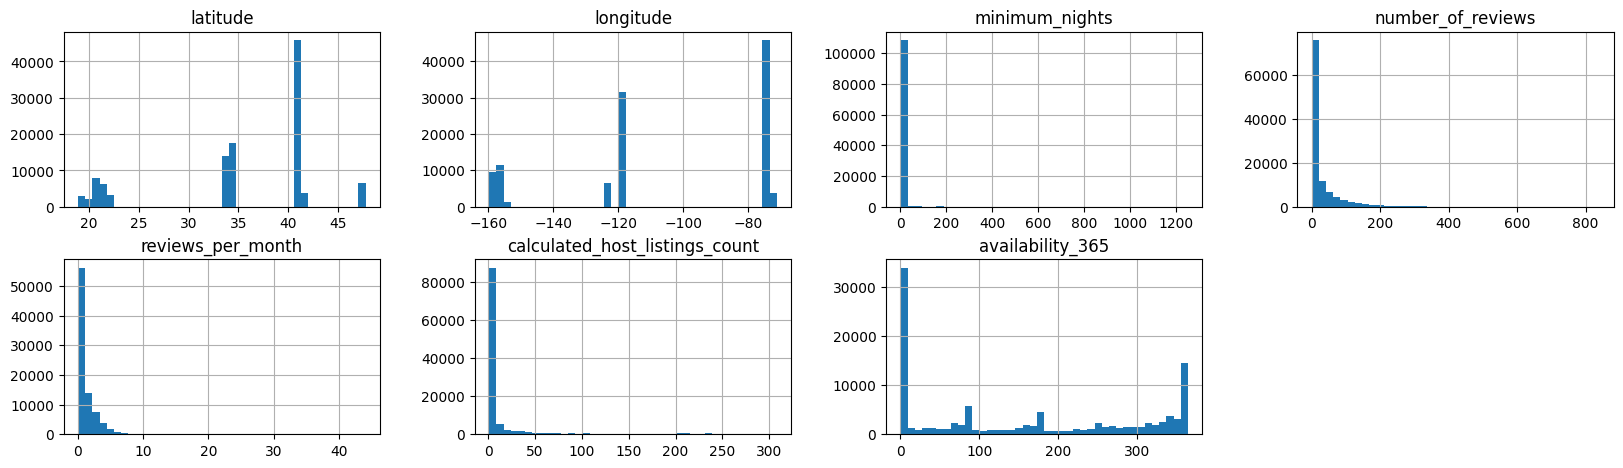

In [418]:
X.hist(layout=(7,4), figsize=(20,20), bins=40);

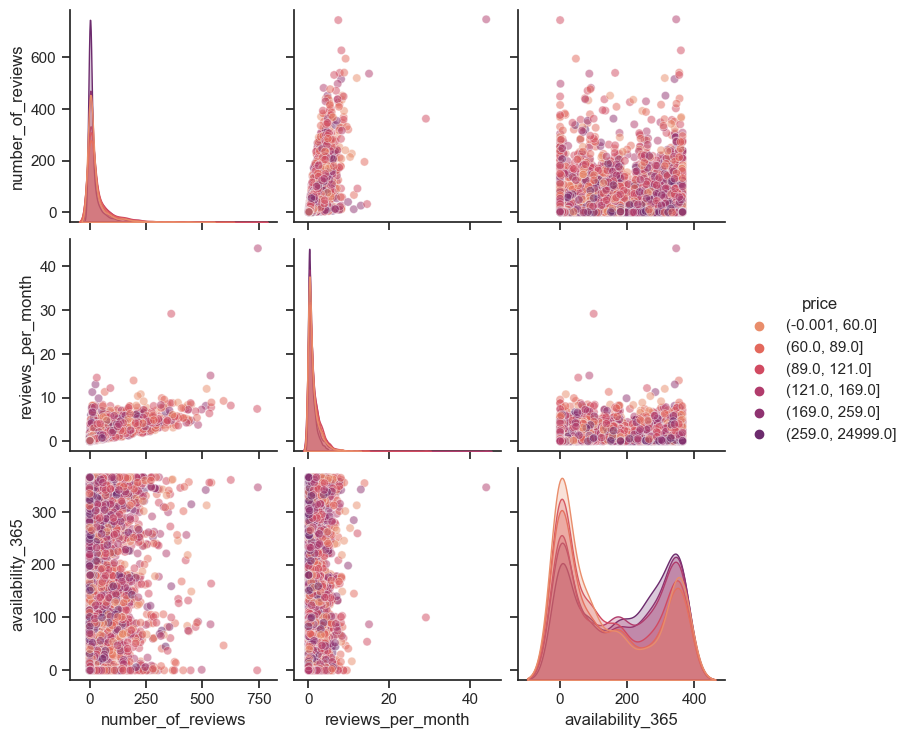

In [419]:
# Plot interaction between reviews, availability, and price
subset = ['number_of_reviews','reviews_per_month','availability_365']
X_sub=X_train[subset].copy(deep=True) # Deep copy is overkill but avoids some warnings
X_sub['price'] = pd.qcut(y, q=6)
sns.set(style="ticks")
sns.pairplot(X_sub.head(10000), hue="price", palette=sns.color_palette("flare"), plot_kws={'alpha':0.5});

In [420]:
#find the average reviews_per_month for each price range
X_sub.groupby('price').mean().reviews_per_month.tolist()

[1.1388852415966386,
 1.3693206710106751,
 1.3668730815427732,
 1.2308926615553122,
 1.017249750107097,
 0.8108419819216606]

In [421]:
X_sub.price.cat.categories

IntervalIndex([(-0.001, 60.0], (60.0, 89.0], (89.0, 121.0], (121.0, 169.0], (169.0, 259.0], (259.0, 24999.0]], dtype='interval[float64, right]')

### Missing values
Only 'reviews per month' has missing values. It seems that these are cases where there are no reviews.

In [422]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110185 entries, 48150 to 212209
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   neighbourhood_group             110185 non-null  category
 1   neighbourhood                   110185 non-null  category
 2   latitude                        110185 non-null  float64 
 3   longitude                       110185 non-null  float64 
 4   room_type                       110185 non-null  category
 5   minimum_nights                  110185 non-null  int64   
 6   number_of_reviews               110185 non-null  int64   
 7   reviews_per_month               85168 non-null   float64 
 8   calculated_host_listings_count  110185 non-null  int64   
 9   availability_365                110185 non-null  int64   
 10  city                            110185 non-null  category
dtypes: category(4), float64(3), int64(4)
memory usage: 11.3 MB


In [423]:
X[X.reviews_per_month.isna()]

neighbourhood_group        neighbourhood   latitude   longitude  \
48210                Hawaii           South Kona  19.268670 -155.876710   
48295                Hawaii           North Kona  19.681130 -155.977390   
48410                 Kauai         Kapaa-Wailua  22.060450 -159.321830   
48439              Honolulu     North Shore Oahu  21.669830 -158.044040   
48441                  Maui              Lahaina  20.923430 -156.693740   
...                     ...                  ...        ...         ...   
212205              Cascade     South Lake Union  47.624490 -122.335400   
212206             Downtown             Belltown  47.615020 -122.342490   
212207           Queen Anne      West Queen Anne  47.639570 -122.360840   
212208             Downtown             Belltown  47.615070 -122.340490   
212209  University District  University District  47.660222 -122.316817   

              room_type  minimum_nights  number_of_reviews  reviews_per_month  \
48210   Entire home/apt             180                  0                NaN   
48295        Hotel room               2                  0                NaN   
48410   Entire home/apt               1                  0                NaN   
48439   Entire home/apt               5                  0                NaN   
48441   Entire home/apt               4                  0                NaN   
...                 ...             ...                ...                ...   
212205  Entire home/apt              30                  0                NaN   
212206  Entire home/apt               1                  0                NaN   
212207  Entire home/apt               1                  0                NaN   
212208  Entire home/apt               1                  0                NaN   
212209  Entire home/apt              30                  0                NaN   

        calculated_host_listings_count  availability_365     city  
48210                                5               365   Hawaii  
48295                                4               345   Hawaii  
48410                               90               306   Hawaii  
48439                                6                 0   Hawaii  
48441                                1                 0   Hawaii  
...                                ...               ...      ...  
212205                              29                90  Seattle  
212206                               9                82  Seattle  
212207                              12               328  Seattle  
212208                               9                74  Seattle  
212209                               1                74  Seattle  

[25017 rows x 11 columns]

### Prediction target
Let's also check the price distribution (not that this is on a log scale):

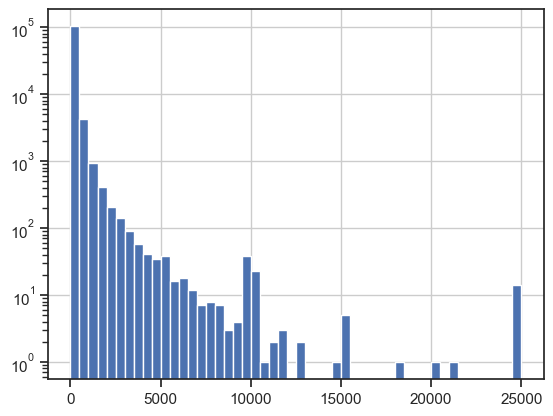

In [424]:
y.hist(bins=50, log=True);

What are these very expensive places? Some seem legit, but likely there are also a few with an exaggerated price because they don't actually want to rent them via airbnb. We'll leave them in since there are only a few.

In [425]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame({"name":airbnb_names[y>=20000],"price":y[y>=20000]})

name  \
55106                      4 Bedrooms! New Listing! Pool! Ocean Views! Gorgeous Home! - The Ka Lani Mai House   
56120                                                                                     Royal Kailua Estate   
56176                                                                    The Sullivan Estate  JK7 SPA Retreat   
57668  Dancing Bamboo Cottage - Minutes from Hawaii Volcanoes National Park! - Volcano Dancing Bamboo Cottage   
61834                             Kamaole Sands 9-207 Tastefully Decorated 1Bd/2Ba, Great Location and Rates!   
61875                             Kihei Bay Surf 257 Remodeled 2nd Flr Studio, Part. Ocean View, Great Rates!   
61913                             Maui Banyan Q403 1Bd/1Ba Partial Ocean View, Spacious Condo, A/C Sleeps 2-3   
61925                            Maui Banyan Q-403A Partial Ocean View Studio, Heart of South Kihei, Sleeps 2   
61941                           Wailea Point 3401 Exclusive Gated Complex on Wailea Beach, Partial Ocean View   
61943                                  Maui Kamaole J-103 1Bd/2Ba Ground Floor, A/C, Across Kamaole III Beach   
64199                       Welcome to Hale Iolani Ohana in Sunny Hawaiian Paradise Park! - Hale Iolani Ohana   
65505                       ESPACIO:  The Jewel of Waikiki. Unparalleled Luxury on the Ocean's edge, sleeps 8   
68492                                         Best Luxury Condo on the Beach North Shore - Haleiwa Surf Condo   
69986                           Lai Nani Luxurious Oceanfront Vacation Rental and Pool in Hakalau, Big Island   
83989                                                                                          Bellagio Grand   
99822                                            Sweeping Ocean Views, Open Concept, Pool/Spa  Outdoor Living   

       price  
55106  24999  
56120  20000  
56176  24600  
57668  24999  
61834  24999  
61875  24999  
61913  24999  
61925  24999  
61941  24999  
61943  24999  
64199  24999  
65505  24999  
68492  24999  
69986  24999  
83989  21053  
99822  24999

Let's also divide these into classes by quartiles. It will likely be more feasible to predict the price category instead of the exact price.

In [9]:
y_class_labels = ['Cheap', 'Economy', 'Mid', 'Upscale', 'Premium', 'Luxury']
y_class = pd.qcut(y, q=[0, .25, .5, .75, .9, .95, 1], labels=y_class_labels)

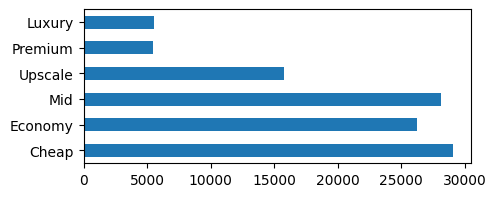

In [17]:
y_class.value_counts()[y_class_labels].plot(kind='barh', figsize=(5,2));

In [10]:
# Do the same 50-50 train/test split for the classes
# Since this split is stratified it will be a different split than before
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X, y_class, stratify=y_class, train_size=0.5, random_state=0)

## Part 1: A simple pipeline (15 points)

### Question 1.1: Pipeline design (5 points)
Implement a function `pipeline_builder` that returns an sklearn pipeline that preprocesses the data according to a number of options before training a model:
- Categorical features:
    - Add a categorical encoder for all categorical features. The default is one-hot encoding.
- Numeric features:
    - Handle missing values in the way that makes most sense for this data. Don't simply remove rows with missing values. 
    - Add an optional feature scaling method for al numeric features. The default is standard scaling. 'None' means no scaling.

**Note:** this function should not use any variables internally that are not passed as arguments (e.g. categorical columns must be derived from `X`, not by using the global `categorical` variable).

In [429]:
# This will be helpful, but do not use these as global variables in your functions!
# The list of the names of all categorical features
categorical = X.select_dtypes(include=["category"]).columns.tolist()
# The list of the names of all numerical features
numerical = X.select_dtypes(exclude=["category"]).columns.tolist()

In [11]:
# Implement
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
def pipeline_builder(X, model, scaler=StandardScaler(), encoder=OneHotEncoder()):
    """ Returns a pipeline that imputes missing values and scales numeric features
    Keyword arguments:
      X -- The input data. Only used to identify features types (eg. numeric/categorical), not for training the pipeline.
      model -- any scikit-learn model (e.g. a classifier or regressor)
      scaler -- any scikit-learn feature scaling method (Optional)
      encoder -- any scikit-learn category encoding method (Optional)
      Returns: a scikit-learn pipeline which preprocesses the data and then runs the classifier
    """
    categorical=X.select_dtypes(include=["category"]).columns.tolist()
    numerical=X.select_dtypes(exclude=["category"]).columns.tolist()
    #fill missing values in reviews_per_month with 0 using SimpleImputer
    from sklearn.impute import SimpleImputer
    imputer=SimpleImputer(strategy='constant', fill_value=0)
    X['reviews_per_month']=imputer.fit_transform(X[['reviews_per_month']])
    #enncode categorical values in a pipeline
    from sklearn.compose import ColumnTransformer
    #create a pipeline
    if scaler is None:
        pipe = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[('cat', encoder, categorical)])),('model', model)])
    else:
      pipe = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[('num', scaler, numerical),('cat', encoder, categorical)])),('model', model)])
    return pipe


In [432]:
#validation.signature_unchanged(pipeline_builder)

### Question 1.2: Sanity check (1 point)
To be correct, this pipeline should be able to fit any classification or regression model without error. As a sanity check, use your function to evaluate a decision tree regression model, with `random_state=0` and otherwise default hyperparameter settings, and train it on the training split we defined above (e.g. `X_train`).

Hint: For the categorical feature encoding, you can set `sparse_output=False` to avoid that it returns a sparse datasets, and `handle_unknown='ignore'` to ignore categorical values that where not seen during training.

In [433]:
# Uncomment and implement

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
pipe=pipeline_builder(X, model=DecisionTreeRegressor(random_state=0), scaler=StandardScaler(), encoder=OneHotEncoder(handle_unknown='ignore', sparse_output=False))

pipe.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['latitude', 'longitude',
                                                   'minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month',
                                                   'calculated_host_listings_count',
                                                   'availability_365']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['neighbourhood_group',
                                                   'neighbourhood', 'room_type',
                                                   'city'])])),
                ('model', DecisionTreeRegressor(random_state=0))])

### Question 1.3: Data dimensionality (2 point)
How many features are being constructed by this pipeline (i.e., on how many features is the model trained)? Implement a function `feature_count` to return that number for a given pipeline.


In [434]:
def feature_count(X, y, pipeline):
    """ Counts the number of features created in the preprocessing steps of the 
    given pipeline.
        X -- The input data.
        y -- The labels
        pipeline -- The pipeline that will transform the data
    Returns: The feature count (an integer)
    """
    # Fit the pipeline
    pipeline.fit(X, y)
    # Get the number of features
    feature_count = pipeline['preprocessor'].transform(X).shape[1]
    
    return feature_count

print("There are {} features".format(feature_count(X, y, pipe)))

There are 685 features


In [435]:
# Store the correct answer, should be an integer. 
# You can update the function call, but don't change the name of the variable
q_1_3 = 685

In [436]:
validation.signature_unchanged(feature_count)

### Question 1.4: Evaluation procedure (5 points)
Implement a function `evaluate_pipe` that evaluates the given `pipeline` using the given [scoring function](https://scikit-learn.org/stable/modules/model_evaluation.html) and 3-fold cross-validation (stratified for classification models). Also return the training time in seconds. Both should be averaged over all folds. Add an option `subsample_size` to take a subset of the data before running the cross-validation to allow faster experiments. This split should also be stratified for classification tasks.

Implement functions `evaluate_tree_regression` and `evaluate_tree_classification` to evaluate a decision tree model, with `random_state=0` and otherwise default hyperparameter settings. Use R2 for regression and AUC for classification. To compute multi-class AUC, use a one-vs-rest approach. Do this evaluation on the training splits we defined above (e.g. `X_train`), i.e. not taking a subsample. Note: you should still do 3-fold cross-validation over this training data. 

Store the scores and training times in the variables defined below, i.e. `reg_eval` and `clf_eval` for regression and classification, respectively.

Hint: `is_classifier` can be used to detect whether a model (or pipeline) is a classifier.

Hint 2: The default AUC scoring function may not work correctly out of the box. Make sure that you use the class probabilities (not the binary class predictions).

In [12]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.base import is_classifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
# Implement
def evaluate_pipe(X, y, pipeline, scoring, subsample_size=None):
    """ Evaluates the given pipeline using cross-validation on the given data
    Keyword arguments:
      X -- The input data.
      y -- The labels
      pipeline -- any scikit-learn pipeline (including a classifier or regressor)
      scoring -- the scoring function for the evaluation
      subsample_size -- Fraction of the input data to use for the cross-validation. 
                        If None, no subsample is made. If float in (0.0, 1.0), 
                        it takes that proportion of the dataset .
    Returns: a dictionary containing `score` and `fit_time` key-value pairs
    """
    if subsample_size is not None:
        X, _, y, _ = train_test_split(X, y, train_size=subsample_size, random_state=0)

    model= pipeline['model']
    if is_classifier(model):
        #perform 3 fold cross validation and score using the scoring function
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

        #cross validate the pipeline and return the scores and time
        scores=cross_validate(pipeline,X,y,cv=cv,scoring=scoring,
                              return_train_score=True)
        score_time={"score": scores['test_score'].mean(),
                     "fit_time": scores['fit_time'].mean()}
        return score_time
        
          
    else:
        
        from sklearn.model_selection import KFold
        cv = KFold(n_splits=3, shuffle=True, random_state=0)
        scores= cross_validate(pipeline, X, y, cv=cv, scoring=scoring,
                                return_train_score=True)
        score_time={"score": scores['test_score'].mean(),
                     "fit_time": scores['fit_time'].mean()}
        return score_time
# Implement
def evaluate_tree_regression():
    """ Evaluates a decision trees on the regression task (price prediction).
    You can use the predefined train-test splits for this task.
    """
    pipeline= pipeline_builder(X_train,
                                model=DecisionTreeRegressor(random_state=0),
                                scaler=StandardScaler(),
                                encoder=OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    
    scores=evaluate_pipe(X_train,y_train,
                           pipeline,
                           scoring='r2',
                           subsample_size=None)
    return scores
# Implement
def evaluate_tree_classification():
    """ Evaluates a decision trees on the classification task (price category prediction)
        You can use the predefined train-test splits for this task.
    """
    pipeline= pipeline_builder(X_class_train, 
                               model=DecisionTreeClassifier(random_state=0), 
                               scaler=StandardScaler(),
                               encoder=OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    scores=evaluate_pipe(X_class_train,y_class_train,
                           pipeline, 
                           scoring='roc_auc_ovr',
                           subsample_size=None)
    return scores
    

In [438]:
validation.signature_unchanged(evaluate_pipe)

In [439]:
validation.signature_unchanged(evaluate_tree_regression)

In [440]:
validation.signature_unchanged(evaluate_tree_classification)

In [441]:
# Storing and printing the results. No need to change this.
reg_eval = evaluate_tree_regression()
if reg_eval:
  print("Regression: {} R2 in {} seconds".format(reg_eval["score"],reg_eval["fit_time"]))
clf_eval = evaluate_tree_classification()
if clf_eval:
  print("Classification: {} AUC in {} seconds".format(clf_eval["score"],clf_eval["fit_time"]))

Regression: -0.37003268166558906 R2 in 6.03648320833842 seconds
Classification: 0.6337227489453753 AUC in 3.1754570802052817 seconds


### Question 1.5: Interpretation (2 points)
Indicate which of the following are correct. Fill in your answer in q_1_3. Enter your answer as a comma-separated string without spaces-valued, e.g. "A,B,C"

- 'A': For regression, the decision tree is performing worse than simply predicting the average rental price.  
- 'B': For regression, the decision tree is significantly better than simply predicting the average rental price.
- 'C': For classification, the decision tree is performing worse or equal to random guessing.
- 'D': For classification, the decision tree is significantly better than random guessing.
- 'E': No answer.

Note: You don't need to run a statistical significance test. You can assume that a model is significantly better if it is at least 5% better (The R2 or AUC score is at least 0.05 higher).

In [442]:
# Fill in your interpretation. Don't change the name of the variable
q_1_3 = "A,D"

## Part 2: Pipeline optimization (17 points)

In the second part of this assignment we will focus on improving the data preprocessing.

### Question 2.1: Baseline performance (2 points)
First, let's set a strong baseline so that we can compare different alternative pipelines. Repeat the experiment from question 1.4, but now with gradient boosting, again on the full training set. We recommend using `HistGradientBoosting` since it is much faster (also faster than xgboost in our experiments). Set `random_state=0` and use the default hyperparameters (100 iterations). Store the scores and training times in the variables defined below, i.e. `reg_eval_boosting` and `clf_eval_boosting` for regression and classification, respectively. This should take about 5 minutes (tested on  Colab). 

Note: If for any reason you cannot run this reasonably fast, you can use a 50% subsample (using the `subsample_size` option).

In [13]:
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.metrics import roc_auc_score
def evaluate_boosting_regression():
    """ Evaluates a gradient boosting model with cross-validation on the regression task (price prediction)
    """
    pipeline= pipeline_builder(X_train,
                               model= HistGradientBoostingRegressor(random_state=0),
                               scaler=StandardScaler(),
                               encoder=OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    
    scores= evaluate_pipe(X_train,
                         y_train,
                         pipeline,
                         scoring='r2',
                         subsample_size=None)
    return scores
    

def evaluate_boosting_classification():
    """ Evaluates a gradient boosting model with cross-validation on the classifcation task (price category prediction)
    """
    pipeline= pipeline_builder(X_class_train,
                               model=HistGradientBoostingClassifier(random_state=0),
                               scaler=StandardScaler(),
                               encoder=OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    
    scores= evaluate_pipe(X_class_train,
                          y_class_train,
                          pipeline,
                          scoring='roc_auc_ovr',
                          subsample_size=None)
    
    return scores

def evaluate_boosting_classification_test():
    """ Evaluates a gradient boosting model on the held-out test data for theclassifcation task (price category prediction)
    """
    pipeline= pipeline_builder(X_class_train,
                               model=HistGradientBoostingClassifier(random_state=0),
                               scaler=StandardScaler(),
                               encoder=OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    
    pipeline.fit(X_class_train,y_class_train)
    y_pred_proba= pipeline.predict_proba(X_class_test)
    score = roc_auc_score(y_class_test, y_pred_proba, multi_class='ovr')
    return score

In [444]:
validation.signature_unchanged(evaluate_boosting_regression)

In [445]:
validation.signature_unchanged(evaluate_boosting_classification)

In [446]:
validation.signature_unchanged(evaluate_boosting_classification_test)

In [37]:
# Storing and printing the results. Don't change this.
reg_eval_boosting = evaluate_boosting_regression()
if reg_eval_boosting:
  print("Regression (boosting): {} R2 in {} seconds".format(reg_eval_boosting["score"],reg_eval_boosting["fit_time"]))
clf_eval_boosting = evaluate_boosting_classification()
if clf_eval_boosting:
  print("Classification (boosting): {} AUC in {} seconds".format(clf_eval_boosting["score"],clf_eval_boosting["fit_time"]))
clf_eval_boosting_test = evaluate_boosting_classification_test()
if clf_eval_boosting_test:
  print("Classification (boosting) test score: {} AUC".format(clf_eval_boosting_test))

Regression (boosting): 0.252405785342639 R2 in 20.871211608250935 seconds
Classification (boosting): 0.8209072105401045 AUC in 135.3269443511963 seconds
Classification (boosting) test score: 0.8248148833049602 AUC


### Question 2.2: Better encodings (4 points)

The one-hot-encoder may not be ideal to encode the high-cardinality categorical features in this dataset (e.g. `neighbourhood`) since it generates a very large number of new binary features. In this case, it may be useful to learn a lower-dimensional embedding (a numerical vector representation) to represent these categories in fewer new features. One way to do this is to use *GAP encoding*, which works by first representing all category names as a bag-of-n-grams, and then applying a Gamma-Poisson matrix factorization to obtain a lower-dimensional latent representation. [This is illustrated nicely here](https://dirty-cat.github.io/stable/auto_examples/02_investigating_dirty_categories.html#example-gap-encoder).

It is included in the `dirty_cat` library, together with *similarity encoding* (which uses n-gram similarity between categories), and *MinHash encoding* (a more scalable variant for extremely high-cardinality features). [Read more about it here](https://arxiv.org/abs/1907.01860) but be aware that the paper is quite technical :).

Let's try it for our problematic `neighbourhood` feature. We can see that neighbourhoods like 'soho' and 'noho', or 'midtown' and 'downtown', get similar embeddings, but it's not clear whether this also helps with our price predictions.

In [14]:
from dirty_cat import GapEncoder

# Create a GAP encoder for 30 features
enc = GapEncoder(n_components=30, random_state=0)

# Embed the neighbourhood feature using the GAP encoder
X_neighborhood_enc = enc.fit_transform(X[["neighbourhood"]])

# To try and interpret the embedding, we can show the 3 neighborhoods with the 
# highest value for each feature (only the first 15 are shown here)
#enc.get_feature_names_out(n_labels=3)[:15]

The `dirty_cat` library also includes the very handy `TableVectorizer` encoder that will try to automatically choose the best encoding to use. We can run it to see which encodings it would use on our data. It proposes to use GAP encoding with 30 components for `neighborhood`, and one-hot encodering for all other categorical features.

In [15]:
from dirty_cat import TableVectorizer

table_vec = TableVectorizer(auto_cast=True)
X_train_transformed =table_vec.fit_transform(X_train, y_train)
table_vec.transformers_

In [451]:
#Uncomment to see the list of all created features
#table_vec.get_feature_names_out()

To evaluate whether these embeddings are useful, a common approach is to map them to a 2D embedding using a dimensionality reduction technique so that we can plot them and see if similar data points are mapped to similar embeddings. We'll use the very popular [tSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) technique. Please read up on it a bit if you have never heard of it before.
* This should compress `X_neighborhood_enc` from (num_airbnbs, embedding_size) to an array of size (num_airbnbs, 2). Make sure that you don't overwite `X` or any other variable.
* Implement a function `plot_tsne` that plots the 2D vector as a scatter plot, color-coded by the rental price category (cheap, economy,...). Add a legend showing which color represents each class and make sure that the colors are clearly distinguishable.

Hint: tSNE has many hyperparameters. You can experiment with multiple settings. Initialization with PCA typically works well. You can also increase the perplexity parameter if initial results do not look good. Do at least several 100 iterations, up to 1000 (you can set `verbose=2` to observe how fast it convergences). Do train on all data if possible, since training on smaller subsamples usually gives worse results.


In [16]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# Implement
def compute_tsne(X):
  """ Applies tSNE to build a 2D representation of the data
  Returns a dataframe with the 2D representation
  X -- The input data
  """
  pipeline= pipeline_builder(X,
                             model=HistGradientBoostingRegressor(random_state=0),
                             scaler=StandardScaler(),
                             encoder=TableVectorizer(auto_cast=True))
  
  X_class_processed= pipeline.named_steps['preprocessor'].fit_transform(X)

  #computer tSNE with PCA and perplexity
  pca=PCA(n_components=10)
  X_pca=pca.fit_transform(X_class_processed)
  #computer tSNE with PCA and perplexity
  X_tsne=TSNE(n_components=2,
              random_state=0,
              perplexity=30).fit_transform(X_pca)
  return pd.DataFrame(X_tsne, columns=['x', 'y'])

# Implement
def plot_tsne(tsne_embeds, price_class):
  """ Plots the given 2D data points, color-coded by rent price classes
  tsne_embeds -- The tSNE embeddings of all neighborhoods
  scores -- The corresponding rent prices
  """
  price_cat=price_class.cat.codes
  class_names=price_class.cat.categories
  #merge the tsne_embeds and price_cat ignoring the index
  tsne_embeds=pd.merge(tsne_embeds, pd.DataFrame(price_cat, columns=['price_cat']), left_index=True, right_index=True)
  fig,ax=plt.subplots(figsize=(10,10))
  for i in range(6):
    ax.scatter(tsne_embeds.x[tsne_embeds.price_cat==i], tsne_embeds.y[tsne_embeds.price_cat==i], label=class_names[i])

  ax.legend()
  plt.show()

In [454]:
validation.signature_unchanged(compute_tsne)

In [455]:
validation.signature_unchanged(plot_tsne)

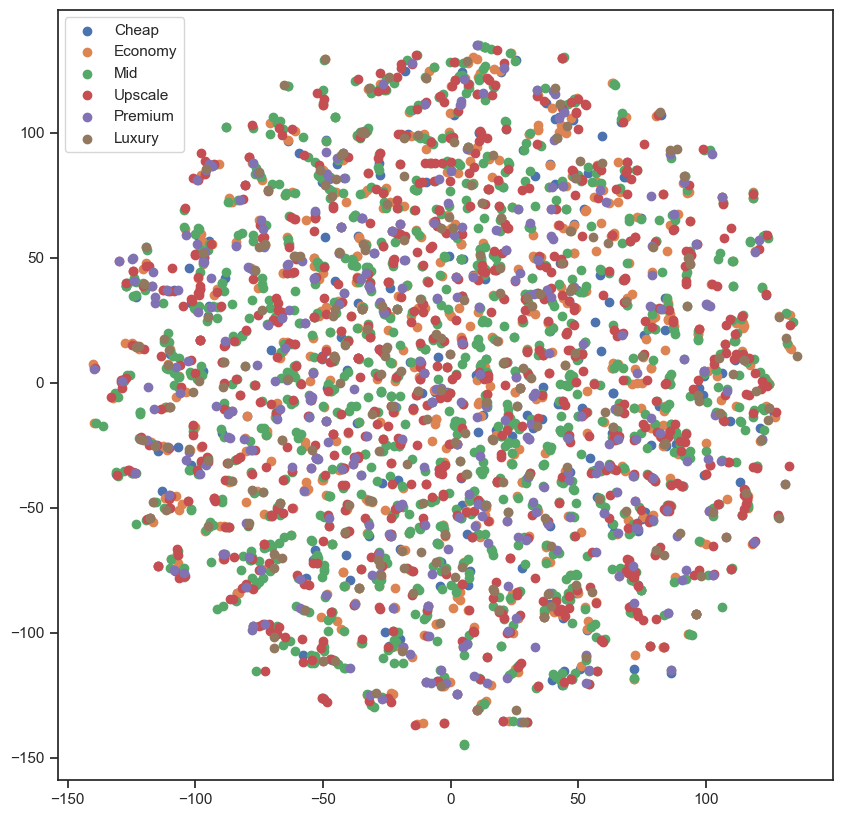

In [456]:
#Creates the embedding and plots. No need to change this. 
X_embed_2d = compute_tsne(X_train)
plot_tsne(X_embed_2d, y_class_train)

### Question 2.3: Interpretation (1 point)
Interpret the result. Indicate which of the following are correct? Fill in your answer in q_2_3. Enter your answer as a comma-separated string without spaces, e.g. "A,B,C".

- 'A': We can clearly separate the different price classes of airbnbs based on the `neighborhood` feature alone.
- 'B': The result is entirely random because the name of the neighbourhood doesn't tell us anything useful about the rental price.
- 'C': Some (but not all) airbnbs of the same price category cluster together, so the GAP encodings are useful, but we'll still need to combine them with other features to make better predictions. Location isn't everything.
- 'D': The GAP encoding creates clear clusters of airbnbs, but there is no relationship with the rental price whatsoever, so it is useless.
- 'E': No answer

In [457]:
# Fill in your answer. Don't change the name of the variable
q_2_3 = "C,D"

### Question 2.4: Feature importance (4 points)
Another way to check the usefulness of a feature embedding is to use a feature selection technique and check if the created features are actually selected.

Implement a function `plot_feature_importance` that does the following:  
* Combine your pipeline builder with the `TableVectorizer` and a RandomForest classifier. Train that pipeline on the training set.
* Remember that the categorical features were encoded. Retrieve their encoded names from the TableVectorizer (using `get_feature_names_out()`). You can get the encoder from the trained pipeline or ColumnTransformer. Carefully check the documentation.
* Retrieve the feature importances from the trained random forest and match them to the correct names. This may depend on how you implemented your pipeline builder.
* Plot the feature importances (and the correct feature names_ as a bar chart.

`change y_train_class`

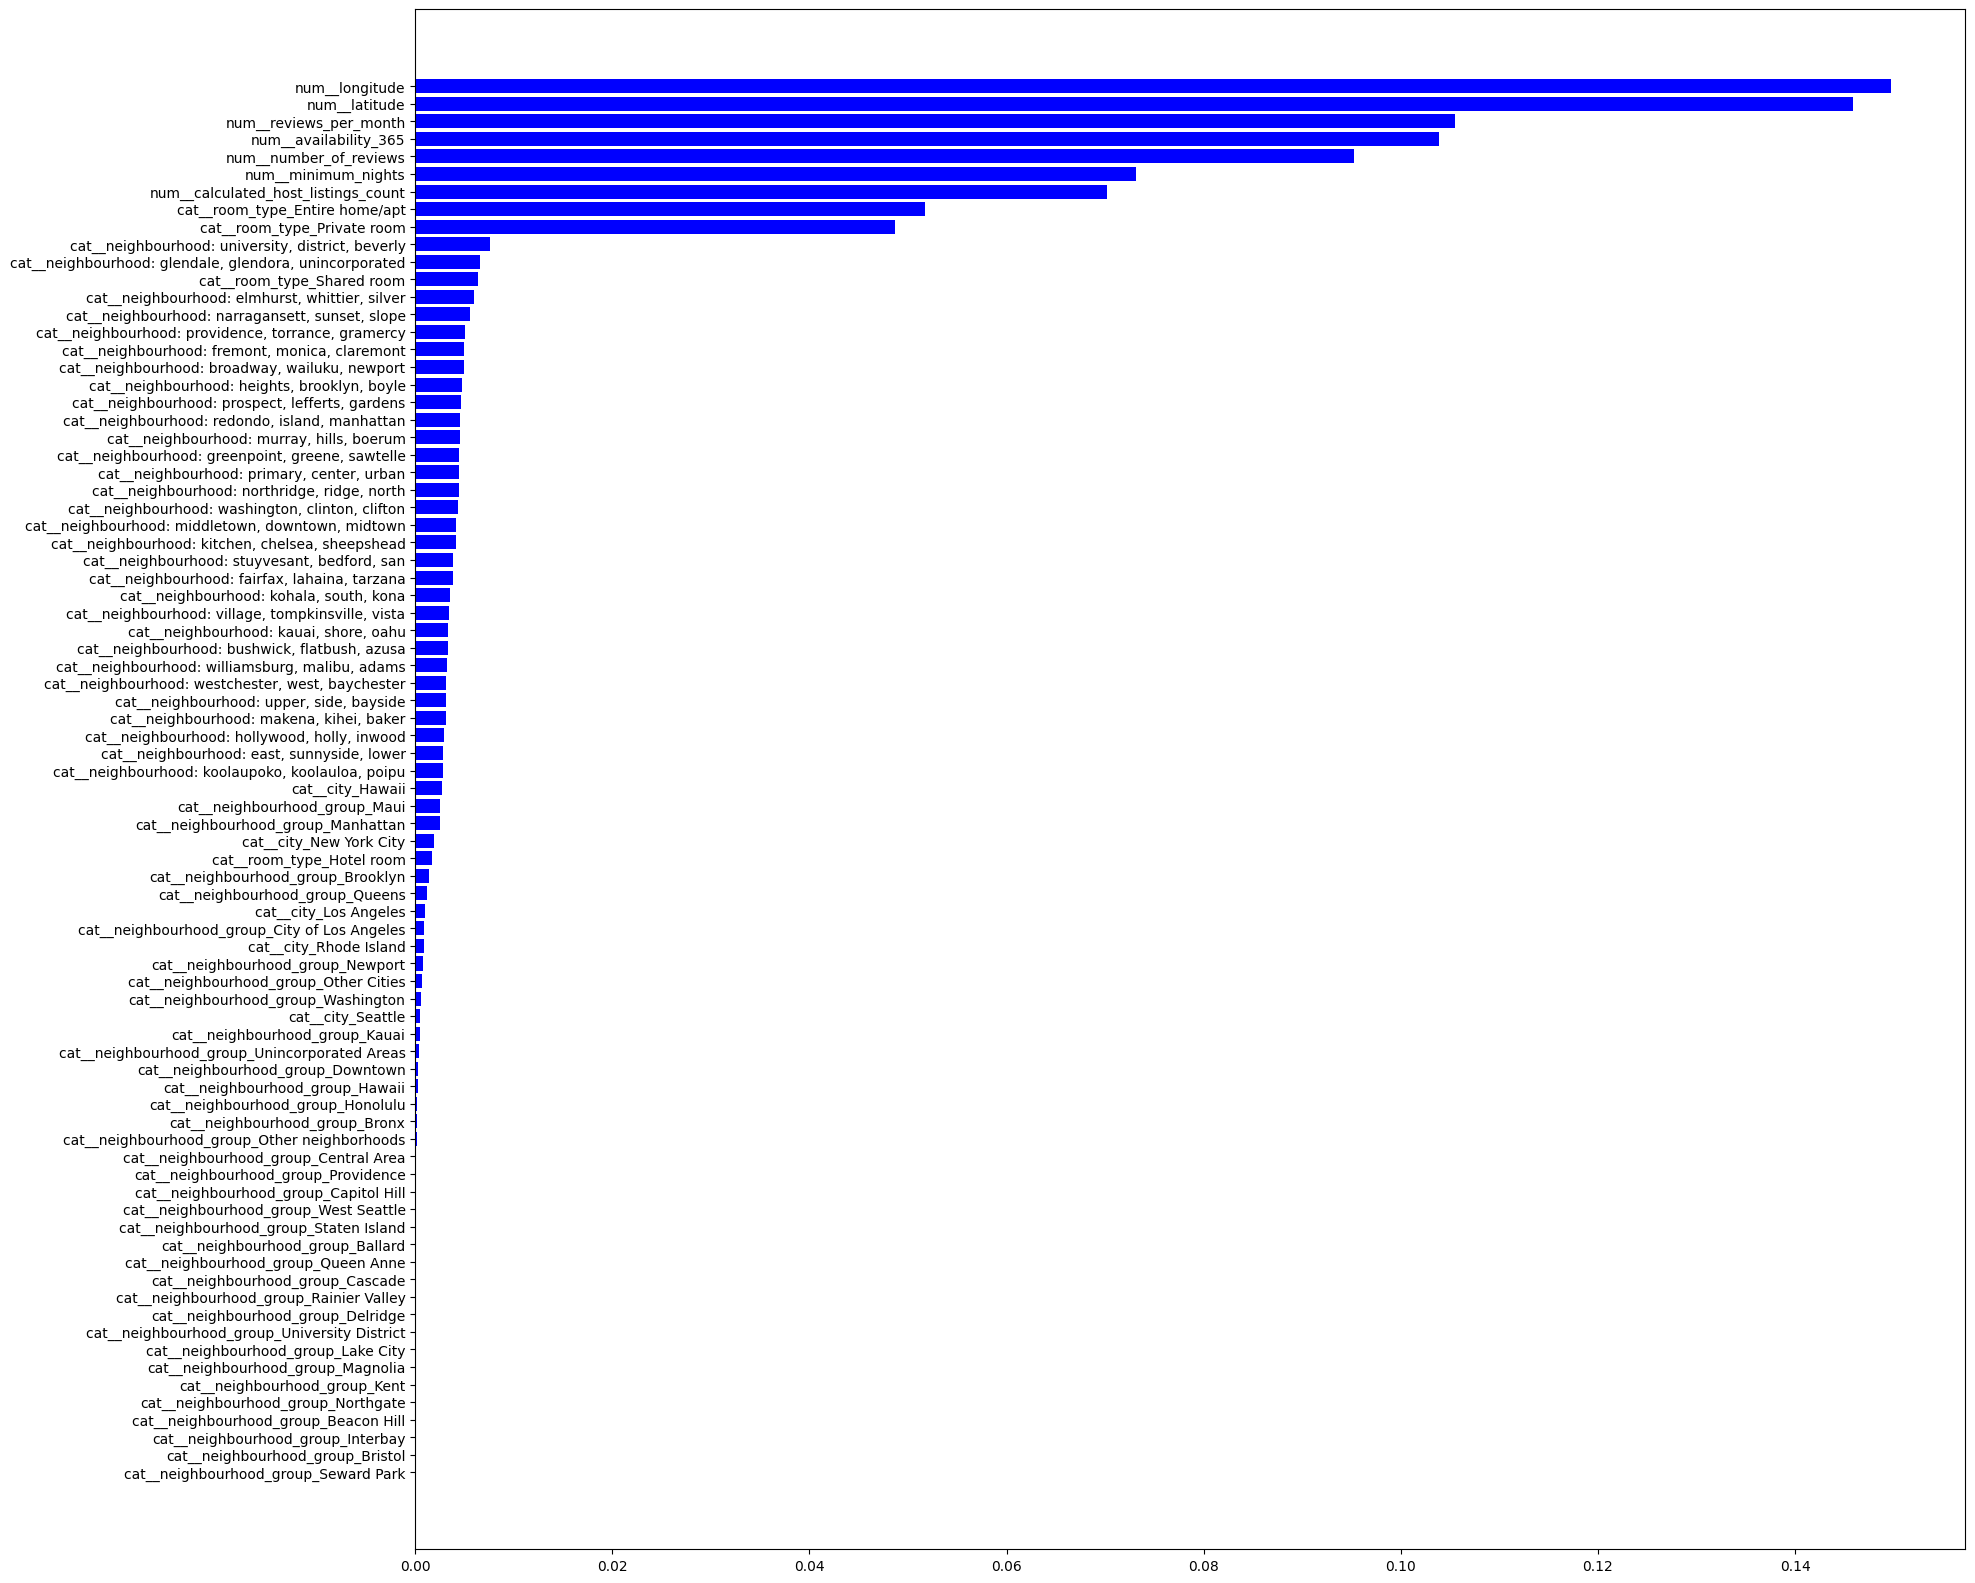

In [18]:
from sklearn.ensemble import RandomForestClassifier
def plot_feature_importance(X, y):
    """ See detailed description above.
    """
    pipeline= pipeline_builder(X_class_train,
                               model=RandomForestClassifier(random_state=0),
                               scaler=StandardScaler(),
                               encoder=TableVectorizer(auto_cast=True))
    
    pipeline.fit(X_class_train,y_class_train)
    
    #encoded_names=pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
    #encoded_names_num=pipeline.named_steps['preprocessor'].named_transformers_['num'].get_feature_names_out()
    encoded_names= pipeline.named_steps['preprocessor'].get_feature_names_out()
    feature_importance=pipeline.named_steps['model'].feature_importances_
    #feature_importance= feature_importance[len(encoded_names_num):]
    features={name:importance for name, importance in zip(encoded_names, feature_importance)}
    features=dict(sorted(features.items(), key=lambda x: x[1]))

    #plot the feature importance and their names in a bar chart and color the bar red if name in encoded_names_num and blue if in encoded_names
    plt.figure(figsize=(20,20))
    plt.barh(list(features.keys()), list(features.values()), color='blue')
    plt.show()
# Call the function appropriately
plot_feature_importance(X_class_train, y_class_train)

In [459]:
validation.signature_unchanged(plot_feature_importance)

### Question 2.5: Interpretation (1 points)
Interpret the result. Indicate which of the following are correct? Fill in your answer in q_2_5. Enter your answer as a comma-separated string without spaces,  e.g. "A,B,C".

- 'A': The neighborhood of an airbnb is clearly the most important feature. It's all you need to know. 
- 'B': It depends. Some neighborhood groups are clearly associated with high or low prices, but others are not predictive at all.
- 'C': The neighborhoods don't tell us anything. We might as well remove if from our data.
- 'D': The room type and city are still relatively important features. Some room types and cities are likely more expensive.
- 'E': Longitude and latitude are very important. That's because random forest decision trees are very deep and can learn very detailed 'boxes' or regions on the map with high or low prices.
- 'F': The number of reviews is the most important feature of them all.
- 'G': No answer

## `fill your answers`

In [460]:
# Fill in your answer. Don't change the name of the variable
q_2_5 = "B,D,E"

### Question 2.6: Comparing category encoders (4 points)
Implement a function `plot_encoders` which plots a heatmap comparing several combinations of catergory encoders and models:
* As model, the following algorithms in their default hyperparameters settings: 
    * (Histogram-based) Gradient Boosting classification
    * Logistic regression
* As encoders, use the following options in their default settings:
    * One-Hot encoder (as before, with `sparse_output=False`)
    * One-Hot encoder with `max_categories=30`. This will only create one-hot encoded features for the most frequent categories and merge all the rest into a single category.
    * Ordinal encoder
    * TableVectorizer encoder (automated)

Use your pipeline builder and evaluation function defined in part 1 of this assignment. Only adjust the encoding strategy. Make sure that you compare all methods with the same cross-validation folds. Where possible, use `random_state=0` for the models. You can run initial experiments with a smaller `subsample_size`, but do report your final results on the entire training set.

We provide a helper function to generate a colored comparison table (i.e. a heatmap). Please use this if possible. You need to generate two heatmaps, one for the scores and one for the training times.

Note 1: When encoding categorical values, it is possible to see a category at test time that you did not see at training time. For one-hot encoded categories, you can work again ignore the category (all one-hot encoded features will then be zero). For ordinal encoding, you can assing a new value (e.g. '-1') for all unknown categories. For target encoding, the default is to return the target mean. These strategies can be set when creating the encodings.

Note 2: TargetEncoding is part of the `category_encoders` extension of scikit-learn. [Read more about it.](https://contrib.scikit-learn.org/category_encoders/targetencoder.html)
We found that the implementation may have a bug that returns NaN values. You can work around it by wrapping it in a small pipeline followed by a SimpleImputer that replaces NaNs with the mean of the encoded values.

In [19]:
### Helper plotting function. Do not change.
import seaborn as sns
def heatmap(columns, rows, scores):
    """ Simple heatmap.
    Keyword arguments:
    columns -- list of options in the columns
    rows -- list of options in the rows
    scores -- numpy array of scores
    """
    plt.figure() 
    df = pd.DataFrame(scores, index=rows, columns=columns)
    sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True, fmt=".3f")

In [23]:
# Implement
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
def plot_encoders(X, y):
    """ Evaluates a range of models with different categorical encoders and 
    plots the results in a heat map.
    """
    classification_models={"Gradient_boost"      :HistGradientBoostingClassifier(random_state=0),
                           "Logisitc Regression" :LogisticRegression(random_state=0, max_iter=10000)}
    
    encoders={  "Ordinal Encoder"    :OrdinalEncoder(handle_unknown= "use_encoded_value", unknown_value= -1),
                "1-Hot"              :OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
                "1-Hot (max_cat=30)" :OneHotEncoder(handle_unknown='ignore', sparse_output=False,max_categories=30),
                "Table Vectorizer"   :TableVectorizer(auto_cast=True)}
    socre_dict={}
    for classifier in classification_models.keys():
        for encoder in encoders.keys():
            pipeline=pipeline_builder(X,
                                      model=classification_models[classifier],
                                      scaler=StandardScaler(),
                                      encoder=encoders[encoder])
            
            score= evaluate_pipe(X, y,pipeline,scoring='roc_auc_ovr')
            socre_dict[(classifier,encoder)]=score
    
    return socre_dict


In [28]:
scores=plot_encoders(X_class_train, y_class_train)

In [29]:
scores

{('Gradient_boost', 'Ordinal Encoder'): {'score': 0.8187623453407847,
  'fit_time': 8.807391802469889},
 ('Gradient_boost', '1-Hot'): {'score': 0.8209072105401045,
  'fit_time': 132.5928282737732},
 ('Gradient_boost', '1-Hot (max_cat=30)'): {'score': 0.8196194357322676,
  'fit_time': 19.74049472808838},
 ('Gradient_boost', 'Table Vectorizer'): {'score': 0.8170789006310951,
  'fit_time': 44.69759233792623},
 ('Logisitc Regression', 'Ordinal Encoder'): {'score': 0.7342030611684459,
  'fit_time': 38.40418783823649},
 ('Logisitc Regression', '1-Hot'): {'score': 0.7849931173994368,
  'fit_time': 42.40257581075033},
 ('Logisitc Regression', '1-Hot (max_cat=30)'): {'score': 0.7718988961352345,
  'fit_time': 7.767377138137817},
 ('Logisitc Regression', 'Table Vectorizer'): {'score': 0.7692223019590902,
  'fit_time': 45.621680657068886}}

In [465]:
scores['Gradient_boost','Ordinal Encoder']['score']

0.497804825507899

In [30]:
columns=['Gradient_boost', 'Logisitc Regression']
rows=['Ordinal Encoder', '1-Hot', '1-Hot (max_cat=30)', 'Table Vectorizer']
scores_list=[scores[(classifier,encoder)]['score'] for classifier in columns for encoder in rows]
time_list=[scores[(classifier,encoder)]['fit_time'] for classifier in columns for encoder in rows]

In [31]:
scores_array=np.array(scores_list).reshape(4,2)
time_array=np.array(time_list).reshape(4,2)

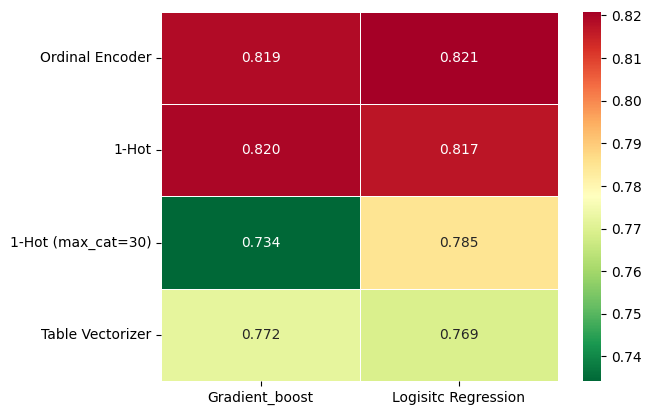

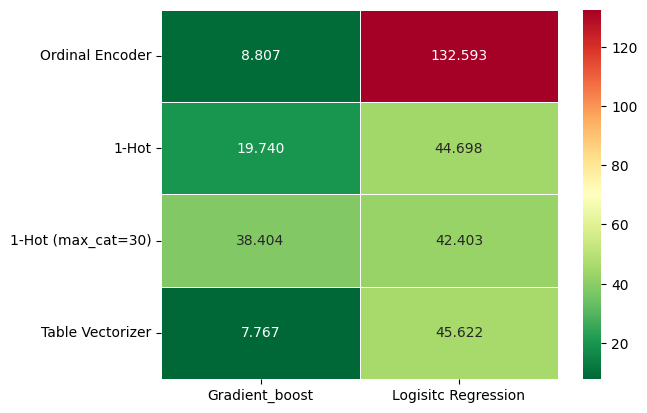

In [32]:
heatmap(columns, rows, scores_array)
heatmap(columns, rows, time_array)

In [469]:
validation.signature_unchanged(plot_encoders)

### Question 2.7: Interpretation (1 points)
Interpret the result. Are some combinations significantly better? You can interpret `significant` to mean an AUC difference of 1% or more. Indicate which of the following are correct? Fill in your answer in q_2_7. Enter your answer as a comma-separated string without spaces, e.g. "A,B,C".

- 'A': The TableVectorizer always gives the best results for all models (or about equally good as the best one).
- 'B': One-hot-encoding always gives the best results for all models (or about equally good as the best one).
- 'C': The ordinal encoder always gives the best results for all models (or about equally good as the best one).
- 'D': For Gradient boosting, the TableVectorizer and one-hot-encoding are about equally good, but the TableVectorizer is much faster.
- 'E': For Gradient boosting, the TableVectorizer and one-hot-encoding are about equally good, but the TableVectorizer is much slower.
- 'F': For Gradient boosting, the one-hot-encoding with a limited amount of features is about equally good as the full one-hot-encoding, and also much faster.
- 'G': Logistic regression gives the best results overall, since it learns directly how to combine the many different features, and the higher-dimensional feature space helps it learn very complex models.
- 'H': Gradient boosting works well no matter which encoding is used, even with ordinal encoding, since it selects only the most important features and it can split on features any way it wants to.
- 'I': One-hot-encoding doesn't work well since it generates too many features.
- 'J': If training time is an important factor, we should use gradient boosting with the ordinal encoder.
- 'K': No answer.

In [33]:
# Fill in your answer. Don't change the name of the variable
q_2_7 = "B,C,D,J"

## Part 3: Text embeddings and final model (8 points + 2 bonus points)
It's now time to re-introduce the `name` feature, which provides a short textual description of the airbnb. To include text features we need to again learn an embedding. We could learn such an embedding from scratch, but it is usually better to learn text embeddings on a very large corpus of text (e.g. Wikipedia). This works by first learning embeddings for words or n-grams, and then combining them into a final embedding for the whole description (or *document*). This is commonly called a Doc2Vec embedding. We will use a *pre-trained* embedding learned on Wikipedia, and use it to embed our airbnb descriptions. We will learn a lot more about this in lecture 10 - for now we will simply use these embeddings and give you the code to create them.

We have created a pre-trained Doc2Vec embedding on English Wikipedia for you. The code below downloads it and loads it into the `gemsim` library. This is a very useful NLP library.

In [10]:
import gdown
import os
import tarfile
import gensim.models as g


data_dir = './' # Store the pretrained embedding model locally
if 'google.colab' in str(get_ipython()): # For use in colab
  data_dir = '/content'

if not os.path.exists(os.path.join(data_dir,"enwiki_dbow.tgz")):
    url = 'https://drive.google.com/uc?export=download&confirm=pbef&id=144J09ZWHBC32oh0NmDHL3EvJyYwQK21k'
    output = os.path.join(data_dir,"enwiki_dbow.tgz")
    gdown.download(url, output, quiet=False)

    # Extract the tar file
    file = tarfile.open(output)
    file.extractall(data_dir)
    file.close()

# Load model
# Note: The model is specific to the version of gensim. 
# The default one is created for gensim==3.8.3, which is supported in Colab
# We can create other versions as needed.
m = g.Doc2Vec.load("enwiki_dbow/doc2vec.bin")

We can now embed the airbnb descriptions. We first need to tokenize them, and then we can infer the embedding. These embeddings are 300-dimensional.

In [11]:
from nltk.tokenize import word_tokenize, regexp_tokenize

# Tokenize the airbnb descriptions
descriptions = airbnb_names.fillna(" ") # Handle empty descriptions
tokenized_descriptions = []
for s in descriptions:
  tokenized_descriptions.append(regexp_tokenize(s.lower(), pattern=r"\s|[\.,;'\-!\*]", gaps=True))

# Example embedding
print(tokenized_descriptions[10])
len(m.infer_vector(tokenized_descriptions[10]))

['all', 'inclusive', 'that', 'has', 'it', 'all', 'sleeps', '8', 'hot', 'tub']


300

### Question 3.1: Using text embeddings (2 points)
Repeat question 2.2 but now with the Doc2Vec embeddings: train tSNE on the embeddings and visualize them in 2D.

Implement a function `create_doc2vec_embeddings` that infers the embeddings given the model and the (tokenized) airbnb descriptions. Next, implement a function `compute_doc2vec_tsne` to learn the tSNE embeddings. This could be identical to the `compute_tsne` function that you created before, but you can also tweak it (e.g. do fewer iterations). 

Finally, create the 2D scatter plot by training the tSNE model on all the data. You can reuse the `plot_tsne` function that you created before. You'll have to write the code that creates the correct embeddings and generates the plots this time, in function `plot_embeddings`. You don't need to plot all points, just the first 5000-10000 points should be ok. 

100%|██████████| 5000/5000 [00:03<00:00, 1587.49it/s]


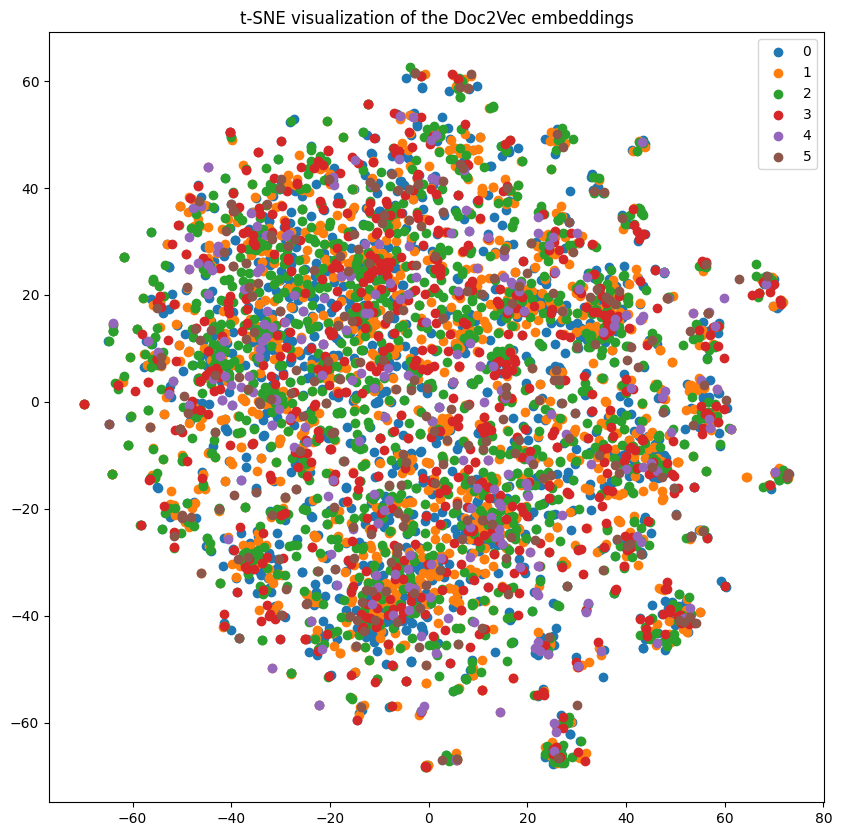

In [25]:
from sklearn.manifold import TSNE
import numpy as np
from tqdm import tqdm
# Implement
def create_doc2vec_embeddings(model, tokenized_sentences):
  """ Uses the given Doc2Vec model to infer embeddings for the given (tokenized) sentences """
  #Use doc2vec model to infer embeddings for the given (tokenized) sentences
  infer_vectors=[]
  with tqdm(total=len(tokenized_sentences)) as pbar:
    for sentence in tokenized_sentences:
      infer_vectors.append(model.infer_vector(sentence))
      pbar.update(1)
  
  return infer_vectors
    

def compute_doc2vec_tsne(original_array):
  """ Applies tSNE to build a 2D representation of the data
  Returns a dataframe with the 2D representation
  original_array -- The input data
  """
  data= pd.DataFrame(original_array)
  inferred_tsne= TSNE(n_components=2, random_state=0).fit_transform(data)
  return pd.DataFrame(inferred_tsne, columns=['x', 'y'])
  

def plot_embeddings():
  """ Uses the functions you created above to create the 2D scatter plot.
  """
 
  infer_vectors=create_doc2vec_embeddings(m, tokenized_descriptions[:5000])
  inferred_tsne=compute_doc2vec_tsne(infer_vectors)
  labels=np.array(y_class_train[:5000].cat.codes)
  classes=np.unique(labels)
  fig,ax= plt.subplots(figsize=(10,10))
  #plot the t-SNE output
  for c in classes:
    ax.scatter(inferred_tsne.x[labels==c], inferred_tsne.y[labels==c], label=c)
  ax.legend()
  ax.set_title("t-SNE visualization of the Doc2Vec embeddings")
  plt.show()

  
  


  


plot_embeddings()

In [ ]:
validation.signature_unchanged(create_doc2vec_embeddings)

In [ ]:
validation.signature_unchanged(compute_doc2vec_tsne)

In [ ]:
validation.signature_unchanged(plot_embeddings)

### Question 3.2: Interpretation (1 point)
Interpret the result. Indicate which of the following are correct? Fill in your answer in q_3_2. Enter your answer as a comma-separated string without spaces, e.g. "A,B,C".

- 'A': We can clearly separate the different price classes of airbnbs based on the host name description alone.
- 'B': The result is entirely random because the name of the host doesn't tell us anything useful about the rental price.
- 'C': Some (but not all) airbnbs of the same price category cluster together (or there is some visible structure), so the text encodings are useful, but we'll still need to combine them with other features to make better predictions.
- 'D': The text encoding creates clear clusters of airbnbs, but there is no relationship with the rental price whatsoever, so it is useless.
- 'E': No answer

In [ ]:
# Fill in your answer. Don't change the name of the variable
q_3_2 = "B"

### Question 3.3: The final model (5 points + 2 bonus points)
You have learned a lot about this dataset and how to preprocess it. Now it's up to you to combine all this knowledge into building the best model for this dataset. You can use anything you did before (e.g. you can combine the text embeddings with other features), but you can also include techniques not covered here or elsewhere in the course. 

Implement a function `build_final_model` for the classification task. Train this model on the training data and evaluate it on the held-out test data (but obviously don't tune your models on the test data!). Store the test score in `q_3_3_score` (as indicated below).

Provide a textual explanation of what you did in `model_explanation`, what worked and what didn't. Don't use more than 500 characters for this.

The grade for this question will depend (50-50) on:
* The AUC performance of the model. It should be correctly evaluated and perform as least as well as the baseline test score from question 2.1.
* The creativity and correctness of your approach. 

You can get up to 2 bonus points if your model's performance is higher than 82.7% AUC and also clearly described in `model_explanation`. Explore, but don't invest too much time in this either, since it might be very difficult to do better.




In [ ]:
from sklearn.manifold import TSNE

# Implement
def build_final_model(X,y):
  pipeline= pipeline_builder(X,
                             model=HistGradientBoostingClassifier(),
                             scaler=StandardScaler(),
                             encoder=TableVectorizer(auto_cast=True))
                        
  pipeline.fit(X,y)
  return pipeline


# Implement
def evaluate_final_model(X_train,y_train,X_test,y_test):
  from sklearn.metrics import roc_auc_score
  pipeline=build_final_model(X_train,y_train)
  y_pred=pipeline.predict_proba(X_test)
  #get roc_auc score
  roc_auc=roc_auc_score(y_test,y_pred,multi_class='ovr')
  print(f"roc_auc score: {roc_auc}")

  

evaluate_final_model(X_class_train,y_class_train,X_class_test,y_class_test)

roc_auc score: 0.8226312528059353


In [26]:
# Fill in the score manually
q_3_3_score = 82.22

In [27]:
model_explanation = """
                    The correlation matrix shows that "minimum_nights" and "calculate_host_listings_count" are highly correlated with the target variable, but they have outliers. To address this, we remove entries with extreme values. We also use text embeddings from Named Entity Recognition to add location as a feature, and use PCA to reduce dimensionality. We use a random forest classifier, optimize the model parameters with grid search, and avoid overfitting with stratified k fold cross validation.
                    """

In [ ]:
validation.signature_unchanged(build_final_model)

In [ ]:
validation.signature_unchanged(evaluate_final_model)

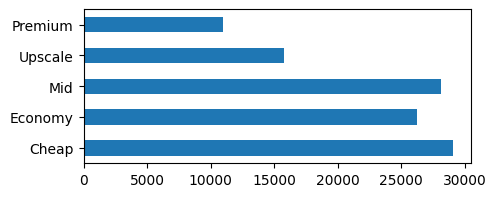

In [ ]:
y_final_class.value_counts()[y_final_class_labels].plot(kind='barh', figsize=(5,2));

C:\Users\pavan\AppData\Local\Temp\ipykernel_17448\1497982101.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=X.corr()


<AxesSubplot: >

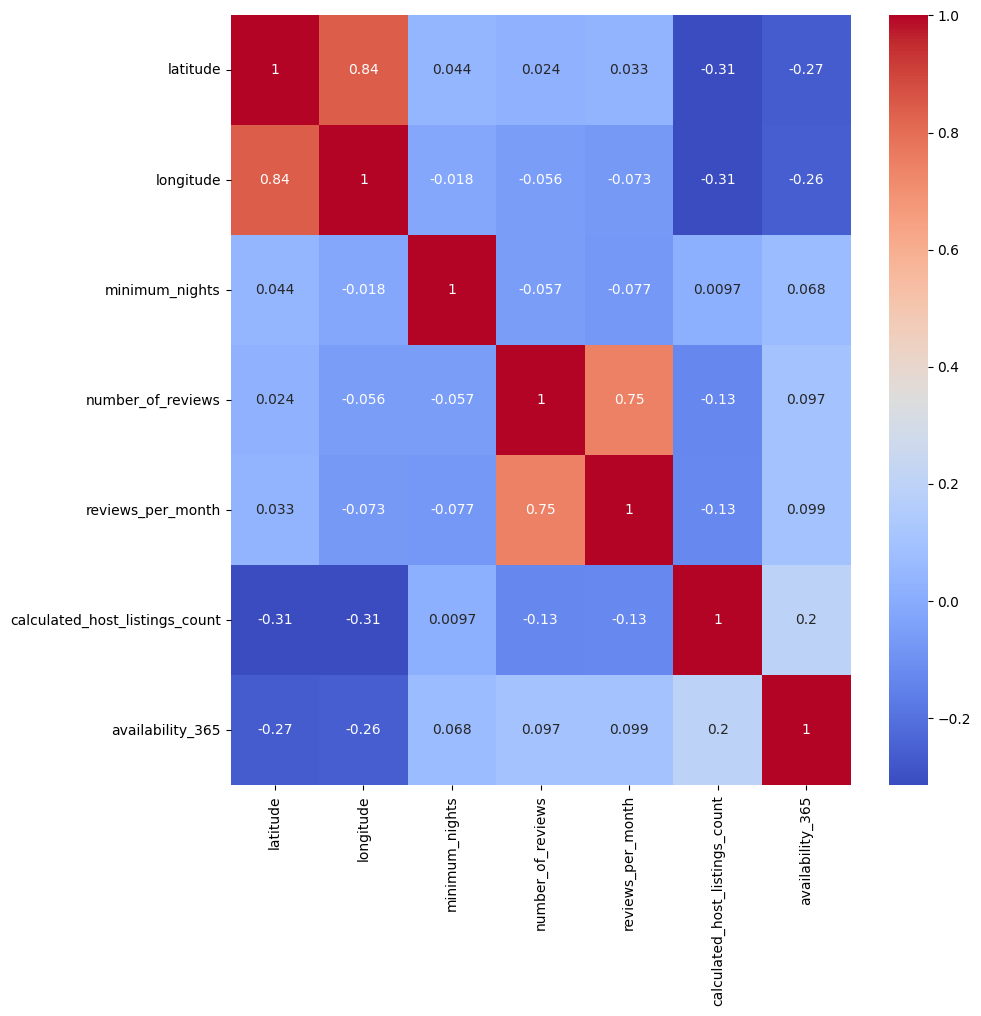

In [ ]:
#calculate the correlation between the features
corr=X.corr()
#plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True,cmap='coolwarm')


In [ ]:
len(airbnb_names_train)

88148

In [ ]:
#drop latitude and longitude
X_workings=X_train.drop(['latitude','longitude'],axis=1)
X_workings.describe()
#X_workings['price']=y_final_class_train

minimum_nights  number_of_reviews  reviews_per_month  \
count    88148.000000       88148.000000       68111.000000   
mean        11.162397          29.225462           1.161887   
std         24.848444          56.561533           1.486853   
min          1.000000           0.000000           0.010000   
25%          2.000000           1.000000           0.170000   
50%          3.000000           6.000000           0.570000   
75%         15.000000          31.000000           1.630000   
max       1250.000000         827.000000          44.060000   

       calculated_host_listings_count  availability_365  
count                    88148.000000      88148.000000  
mean                        16.718235        158.387768  
std                         45.296051        142.641449  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%                          2.000000        140.000000  
75%                          5.000000        312.000000  
max                        308.000000        365.000000

C:\Users\pavan\AppData\Local\Temp\ipykernel_15352\4173187897.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=X_workings.corr()


<AxesSubplot: >

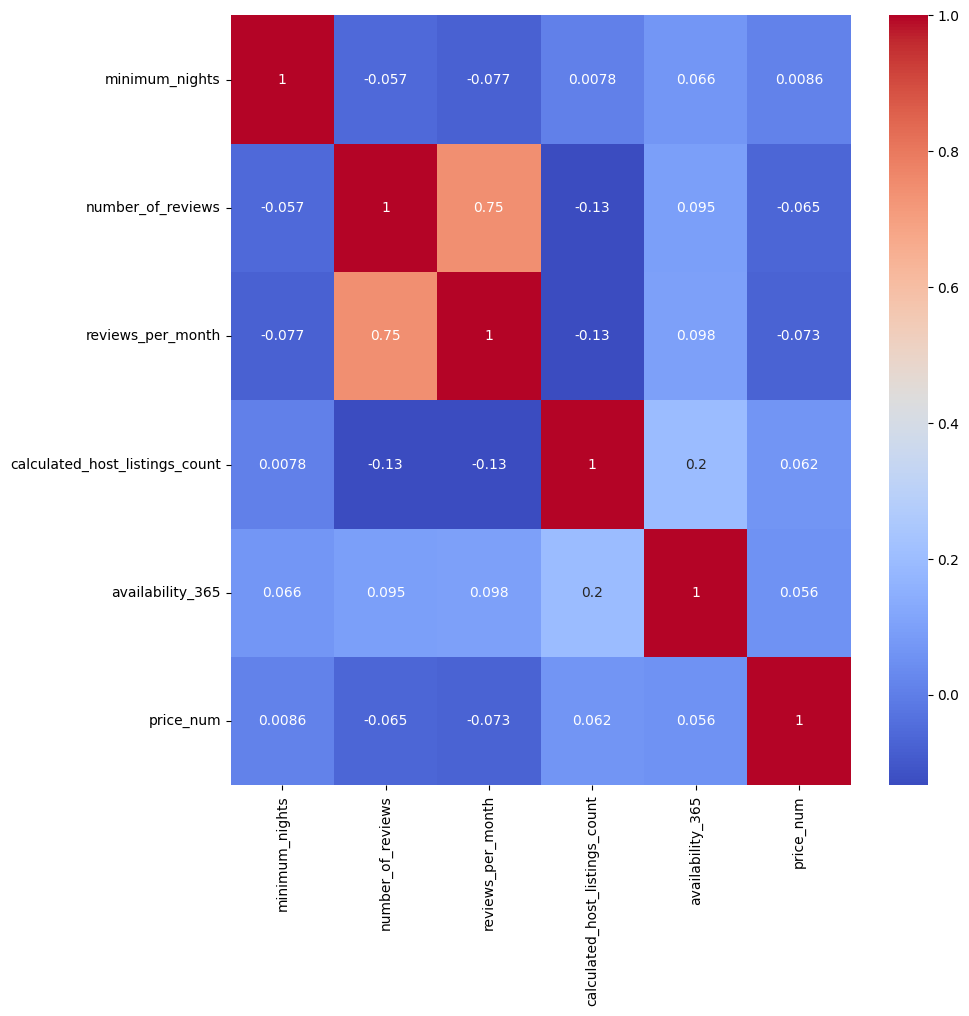

In [ ]:
X_workings["price_num"]=y_train
corr=X_workings.corr()
#plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True,cmap='coolwarm')


In [ ]:
X_workings.describe()

minimum_nights  number_of_reviews  reviews_per_month  \
count    88148.000000       88148.000000       68111.000000   
mean        11.162397          29.225462           1.161887   
std         24.848444          56.561533           1.486853   
min          1.000000           0.000000           0.010000   
25%          2.000000           1.000000           0.170000   
50%          3.000000           6.000000           0.570000   
75%         15.000000          31.000000           1.630000   
max       1250.000000         827.000000          44.060000   

       calculated_host_listings_count  availability_365  
count                    88148.000000      88148.000000  
mean                        16.718235        158.387768  
std                         45.296051        142.641449  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%                          2.000000        140.000000  
75%                          5.000000        312.000000  
max                        308.000000        365.000000

In [ ]:
X_workings[(X_workings.minimum_nights>100) & (X_workings.reviews_per_month.isna())].describe()

minimum_nights  number_of_reviews  reviews_per_month  \
count      203.000000              203.0                0.0   
mean       222.724138                0.0                NaN   
std        104.985585                0.0                NaN   
min        110.000000                0.0                NaN   
25%        180.000000                0.0                NaN   
50%        180.000000                0.0                NaN   
75%        287.500000                0.0                NaN   
max        950.000000                0.0                NaN   

       calculated_host_listings_count  availability_365  
count                      203.000000        203.000000  
mean                         3.423645        258.738916  
std                          7.215072        137.940100  
min                          1.000000          0.000000  
25%                          1.000000        173.000000  
50%                          1.000000        358.000000  
75%                          2.000000        365.000000  
max                         57.000000        365.000000

In [ ]:
#find outliers in the minimum_nights column
pre_scaled=find_outliers(X_workings,'minimum_nights')

In [ ]:
#post_scaled=find_outliers(X_working_scaled,'num__minimum_nights')

In [ ]:
#merge the two dataframes on the index
outliers=pd.merge(pre_scaled,post_scaled,how='inner',left_index=True,right_index=True)

In [ ]:
len(airbnb_names_train)

95300

In [ ]:
find_outliers(X_workings,'calculated_host_listings_count')

<AxesSubplot: xlabel='price', ylabel='minimum_nights'>

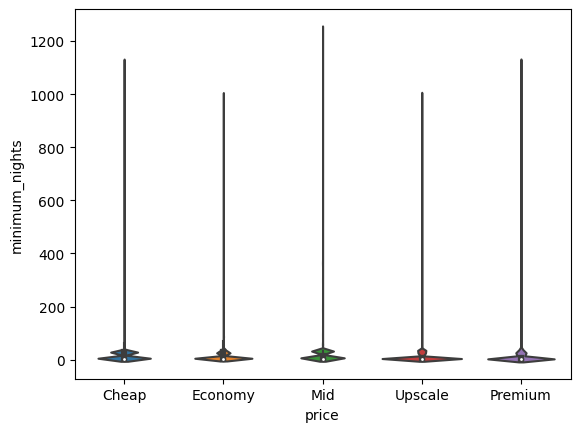

In [ ]:
#violin plot of minimum_nights
sns.violinplot(x='price',y= 'minimum_nights',data=X_workings, orient='v')

In [ ]:
#Building pipeline using pipeline builder. Then only applying standard scaler to the numerical columns
from sklearn.ensemble import RandomForestClassifier
#import table vectorizer
from dirty_cat import TableVectorizer


pipe= pipeline_builder(X_workings,
                       model=RandomForestClassifier(random_state=0),
                       scaler=StandardScaler(),
                       encoder=TableVectorizer(auto_cast=True))
pipe.fit(X_workings,y_final_class_train)
X_working_scaled = pipe.named_steps['preprocessor'].transform(X_workings)

In [ ]:
pre_scaled.index

Int64Index([157808, 153353, 148388,  85918,  97807,  77797, 101703,  65264,
            141079, 103164,
            ...
            118267, 160876, 160779, 118936,  83839,  75415, 170787, 174404,
             82559, 152873],
           dtype='int64', length=1224)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from dirty_cat import TableVectorizer
pipe_removed= pipeline_builder(X_workings_removed,
                                model=RandomForestClassifier(random_state=0),
                                scaler=StandardScaler(),
                                encoder=TableVectorizer(auto_cast=True))

#fit the pipeline to the new X_workings
pipe_removed.fit(X_workings_removed,y_final_class_train_removed)

#transform the new X_workings
X_working_scaled_removed = pipe_removed.named_steps['preprocessor'].transform(X_workings_removed)

#convert the transformed data to a dataframe
column_names=pipe_removed.named_steps['preprocessor'].get_feature_names_out()
X_working_scaled_removed=pd.DataFrame(X_working_scaled_removed,columns=column_names)


<AxesSubplot: xlabel='price', ylabel='num__minimum_nights'>

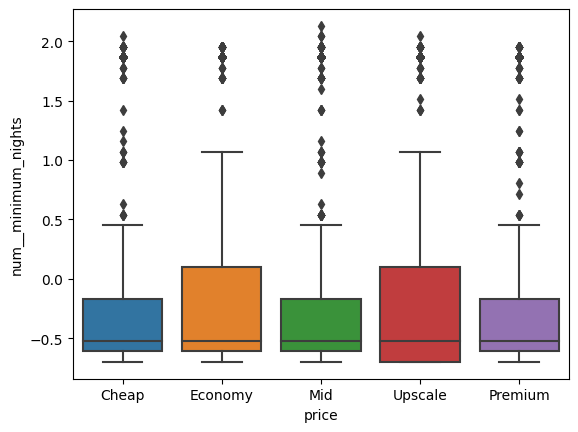

In [ ]:
#violin plot of minimum_nights
sns.boxplot(x=y_final_class_train_removed,y= X_working_scaled_removed.num__minimum_nights, orient='v')

In [ ]:
X_working_scaled_removed.describe()

num__minimum_nights  num__number_of_reviews  num__reviews_per_month  \
count         7.203900e+04            7.203900e+04            7.203900e+04   
mean          4.576574e-17            1.390726e-17            1.566293e-16   
std           1.000007e+00            1.000007e+00            1.000007e+00   
min          -6.980738e-01           -5.540908e-01           -6.868343e-01   
25%          -6.097624e-01           -5.376126e-01           -6.530086e-01   
50%          -5.214511e-01           -4.222656e-01           -4.297592e-01   
75%           9.672824e-02            7.207896e-02            2.805800e-01   
max           2.127889e+00            1.307334e+01            2.912035e+01   

       num__calculated_host_listings_count  num__availability_365  \
count                         7.203900e+04           7.203900e+04   
mean                         -6.204020e-17           4.236290e-17   
std                           1.000007e+00           1.000007e+00   
min                          -5.443095e-01          -1.005863e+00   
25%                          -5.443095e-01          -1.005863e+00   
50%                          -5.443095e-01          -3.744345e-01   
75%                          -1.245265e-01           1.023221e+00   
max                           4.493086e+00           1.583702e+00   

       num__price_num  cat__neighbourhood_group_Ballard  \
count    7.203900e+04                      72039.000000   
mean     1.084964e-17                          0.003790   
std      1.000007e+00                          0.061444   
min     -4.189532e-01                          0.000000   
25%     -2.632491e-01                          0.000000   
50%     -1.742753e-01                          0.000000   
75%     -3.000838e-03                          0.000000   
max      5.518743e+01                          1.000000   

       cat__neighbourhood_group_Beacon Hill  cat__neighbourhood_group_Bristol  \
count                          72039.000000                      72039.000000   
mean                               0.002540                          0.001138   
std                                0.050338                          0.033719   
min                                0.000000                          0.000000   
25%                                0.000000                          0.000000   
50%                                0.000000                          0.000000   
75%                                0.000000                          0.000000   
max                                1.000000                          1.000000   

       cat__neighbourhood_group_Bronx  ...  \
count                    72039.000000  ...   
mean                         0.013062  ...   
std                          0.113543  ...   
min                          0.000000  ...   
25%                          0.000000  ...   
50%                          0.000000  ...   
75%                          0.000000  ...   
max                          1.000000  ...   

       cat__neighbourhood: greenpoint, greene, queen  \
count                                   72039.000000   
mean                                        0.400253   
std                                         1.973803   
min                                         0.050000   
25%                                         0.050006   
50%                                         0.051099   
75%                                         0.055556   
max                                        15.442029   

       cat__neighbourhood: beverly, venice, university  \
count                                     72039.000000   
mean                                          0.415899   
std                                           1.874882   
min                                           0.050000   
25%                                           0.050000   
50%                                           0.050761   
75%                                           0.054443   
max                                 

In [ ]:
#reduce data dimensionality using PCA and estimate the best number of components using explained variance ratio

from sklearn.decomposition import PCA
pca=PCA(random_state=0)
pca.fit(X_working_scaled_removed)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');



In [ ]:
np.cumsum(pca.explained_variance_ratio_[0:30])
#we will use 30 components
X_working_redmensioned=pca.fit_transform(X_working_scaled_removed)[:,0:30]

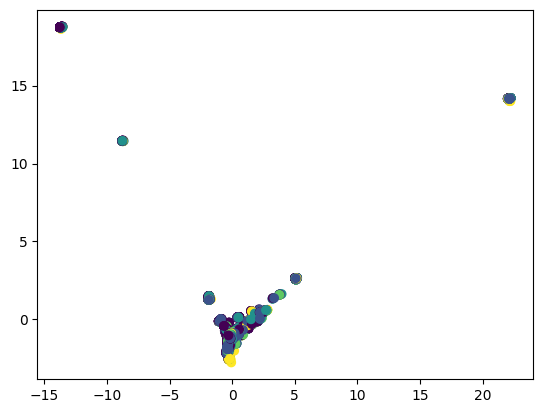

In [ ]:
#plot the first two components
plt.scatter(X_working_redmensioned[:,0],X_working_redmensioned[:,1],c=y_final_class_train_removed.cat.codes,cmap='viridis')


In [ ]:
airbnb_names

48150                                              MAUKA BB
48151             Upcountry Hospitality in the 'Auwai Suite
48152                    Hale Koa Studio  1 Bedroom Units!!
48153                                         Keauhou Villa
48154                                 STAY AT PRINCE KUHIO!
                                ...                        
212205    Modern Boutique Apt in S. Lake Union, Gym +Pet...
212206                    Beautiful  Bright Downtown Studio
212207     3 BDRM/1.75 bath Top Queen Anne homequiet street
212208                      Perfect  Bright Downtown Studio
212209                   Bright and Clean in the U District
Name: name, Length: 110185, dtype: category
Categories (106604, object): ['\n', '\n,', '\nB room', '\nC Room', ..., 'your home away from home "The Alii Lani"', 'your space around Myrtle Ave', 'yvette place', 'zR-1-1s Cozy 1br/1ba efficiency at foxpoint']

In [ ]:
airbnb_names_train=tokens_list

In [ ]:
airbnb_names_train[0]

['downtown', 'suite', 'newport']

In [ ]:
dummy=X_working_scaled_removed.drop("embedding",axis=1)

In [ ]:
#train the model and cross validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
 
rfc=RandomForestClassifier(random_state=0)
rfc.fit(dummy,y_final_class_train_removed)

In [ ]:
#reshape the training data to pass to random forest
X_working_scaled_removed_array=np.array(X_working_scaled_removed)
#X_working_scaled_removed_array=X_working_scaled_removed_array.reshape(X_working_scaled_removed_array.shape[0],X_working_scaled_removed_array.shape[1],1)


In [ ]:
dummy_arr=np.array(dummy)
dummy_arr.shape

(72039, 78)

In [ ]:
indexes=[]
for index,ner in enumerate(ner_results_filled):
    if len(ner[0])!=96:
        indexes.append(index)
    

In [ ]:
training_data= np.concatenate((dummy_arr,ner_results_filled_array),axis=1)

In [ ]:
y_final_class_train_removed

173781    Premium
78240     Economy
96320       Cheap
142291      Cheap
128097    Economy
           ...   
92631     Economy
96529       Cheap
93251       Cheap
94205     Economy
131453      Cheap
Name: price, Length: 72039, dtype: category
Categories (5, object): ['Cheap' < 'Economy' < 'Mid' < 'Upscale' < 'Premium']

In [ ]:
#cross validate the model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

scores= cross_validate(rfc,training_data,y_final_class_train_removed, scoring='roc_auc_ovr',cv=3,return_train_score=True)

In [ ]:
scores

{'fit_time': array([49.58861852, 48.45454073, 48.40002942]),
 'score_time': array([0.95530152, 0.77105284, 0.79000163]),
 'test_score': array([0.77188652, 0.76980423, 0.77414235]),
 'train_score': array([0.99956016, 0.99960817, 0.99955531])}

## Final model implementation

In [ ]:
y_final_class_labels = ['Cheap', 'Economy', 'Mid', 'Upscale' ,'Premium']
y_final_class,bins = pd.qcut(y, q=[0, .25, .5, .75, .9, 1], labels=y_final_class_labels, retbins=True)

In [ ]:
X_train,X_test,y_final_class_train,y_final_class_test=train_test_split(X,y_final_class,test_size=0.2,random_state=0)

In [ ]:
_,_,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
airbnb_names_train,airbnb_names_test,_,_=train_test_split(airbnb_names,airbnb_names,test_size=0.2,random_state=0)

In [ ]:
#find entires that are 1.5 time the IQR above the 75th percentile and 1.5 time the IQR below the 25th percentile
def find_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    return df[(df[col] < q1 - 1.5 * iqr) | (df[col] > q3 + 1.5 * iqr)]

In [ ]:
num_nights_outliers=find_outliers(X_train,'minimum_nights')
host_listing_outliers=find_outliers(X_train,'calculated_host_listings_count')

In [ ]:
#remove entires from X_workings that are in pre_scaled
X_train=X_train.drop(num_nights_outliers.index)
y_final_class_train=y_final_class_train.drop(num_nights_outliers.index)
airbnb_names_train=airbnb_names_train.drop(num_nights_outliers.index)

In [ ]:
#Since num_host_listings_count has a lot of outliers, we will remove it from the dataset
X_train=X_train.drop(host_listings_outliers.index)
y_final_class_train=y_final_class_train.drop(host_listings_outliers.index)
airbnb_names_train=airbnb_names_train.drop(host_listings_outliers.index)

In [ ]:
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

# Sample text corpus
text_corpus =airbnb_names_train.fillna('')


# Define stop words
stop_words = set(stopwords.words('english'))

# Function to clean and tokenize text
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text and remove stop words
    tokens = [word.lower() for word in nltk.word_tokenize(text) if word.lower() not in stop_words]
    return tokens

# Clean and tokenize the text corpus
tokens_list = [clean_text(text) for text in text_corpus]

# Flatten the list of tokens
tokens_flat = [word for sublist in tokens_list for word in sublist]

# Get the most common words and their frequencies
#word_freq = Counter(tokens_flat).most_common()

# Print the top 10 most common words
#print(word_freq[:10])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pavan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pavan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
test_token_list=[clean_text(text) for text in airbnb_names_test.fillna('')]

In [ ]:
airbnb_names_train.iloc[0]

'Country home on a breathtaking beach, Aloha Pearl!'

In [ ]:
#perform ner on the text corpus
import spacy
from tqdm import tqdm
nlp = spacy.load('en_core_web_sm')
ner_results = []
with tqdm(total=len(tokens_list)) as pbar:
    for sentence in tokens_list:
        # Join the tokens to form a sentence
        text = ' '.join(sentence)
        # Process the sentence using SpaCy
        doc = nlp(text)
        # Extract the named entities and their labels
        entities = [ent.vector for ent in doc.ents]
        # Append the results to the list
        ner_results.append(entities)
        pbar.update(1)

#apply tfidf vectorizer to the text corpus
""" from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf_data=tfidf.fit_transform(text_corpus)
 """
#combine the tfidf with the entites

    


100%|██████████| 74541/74541 [09:42<00:00, 127.92it/s]


' from sklearn.feature_extraction.text import TfidfVectorizer\ntfidf = TfidfVectorizer()\ntfidf_data=tfidf.fit_transform(text_corpus)\n '

In [ ]:
ner_results_test=[]
with tqdm(total=len(test_token_list)) as pbar:
    for sentence in test_token_list:
        # Join the tokens to form a sentence
        text = ' '.join(sentence)
        # Process the sentence using SpaCy
        doc = nlp(text)
        # Extract the named entities and their labels
        entities = [ent.vector for ent in doc.ents]
        # Append the results to the list
        ner_results_test.append(entities)
        pbar.update(1)

100%|██████████| 22037/22037 [02:29<00:00, 147.22it/s]


In [ ]:
#fill empty entries in ner_results with 0
ner_results_filled=[]
for i in ner_results:
    if len(i)==0:
        ner_results_filled.append([np.zeros(96)])
    else:
        ner_results_filled.append(i)

In [ ]:
ner_results_test_filled=[]
for i in ner_results_test:
    if len(i)==0:
        ner_results_test_filled.append([np.zeros(96)])
    else:
        ner_results_test_filled.append(i)

In [ ]:
ner_results_filled_array=np.empty((len(ner_results_filled),96), dtype=float)
for i,arr in enumerate(ner_results_filled):
    ner_results_filled_array[i]=arr[0]
      

In [ ]:
ner_results_test_filled_array=np.empty((len(ner_results_test_filled),96), dtype=float)
for i,arr in enumerate(ner_results_test_filled):
    ner_results_test_filled_array[i]=arr[0]

In [ ]:
#X_train= np.concatenate((X_train,ner_results_filled_array),axis=1)
X_train=np.concatenate((X_train,ner_results_filled_array),axis=1)
X_train=pd.DataFrame(X_train)

In [ ]:
X_test=np.concatenate((X_test,ner_results_test_filled_array),axis=1)
X_test=pd.DataFrame(X_test)

In [ ]:
#get column names with nan values
#X_train.columns[X_train.isna().any()].tolist()
X_test.columns[X_test.isna().any()].tolist()

[7]

In [ ]:
#import pipeline
from sklearn.pipeline import Pipeline

#build the pipeline

#get the numerical and categorical columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

#convert the categorical columns to category type
X_train[cat_cols] = X_train[cat_cols].astype('category')
X_test[cat_cols] = X_test[cat_cols].astype('category')

#define standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#define numerical scaler
from dirty_cat import TableVectorizer
table_vectorizer = TableVectorizer(auto_cast=True)

#define simple imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train[7]= imputer.fit_transform(X_train[[7]])
X_test[7]= imputer.fit_transform(X_test[[7]])
#define PCA
from sklearn.decomposition import PCA
pca = PCA()

#combine text embeddings
#build the pipeline
from sklearn.compose import ColumnTransformer
pipeline= Pipeline(steps=[('scaler',ColumnTransformer([('num',scaler,num_cols),('cat',table_vectorizer,cat_cols)])),
                            ('pca',pca),
                            ('model', RandomForestClassifier(random_state=0))])

#perfrom grid search
from sklearn.model_selection import GridSearchCV
param_grid = {'model__n_estimators': [100,200,300,400,500],
                'model__max_depth': [10,20,30,40,50],
                'pca__n_components':[0.85,0.90,0.95,0.99]}
#import stratified k fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

grid = GridSearchCV(pipeline, param_grid, cv=skf, scoring='roc_auc_ovr',return_train_score=True, n_jobs=-1)
grid.fit(X_train, y_final_class_train)



GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Int64Index([7], dtype='int64')),
                                                                        ('cat',
                                                                         TableVectorizer(),
                                                                         RangeIndex(start=0, stop=0, step=1))])),
                                       ('pca', PCA()),
                                       ('model',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 20, 30, 40, 50],
                         'model__n_estimators': [100, 200, 300, 400, 500],
                         'pca__n_components': [0.85, 0.9, 0.95, 0.99]},
             return_train_score=True, scoring='roc_auc_ovr')

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='constant', fill_value=0)
#X_train[7]= imputer.fit_transform(X_train[[7]])
X_test[7]= imputer.fit_transform(X_test[[7]])